In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use('seaborn-whitegrid')

device = "cuda" if torch.cuda.is_available() else "cpu"

class MultiRBFnn(nn.Module):
    def __init__(self, in_feature, add_rbf_num, device):
        super(MultiRBFnn, self).__init__()

        self.add_rbf_num = add_rbf_num  # additional RBFs number
        self.in_feature = in_feature    # count features
        self.device = device
        self.centers_list = []
        self.sigmas_list = []
        self.weights_list = []

        self.change_th = 3

    def first_rbf_parameter(self, input_data, target): # done

        # input_data shape : (data_num)
        # target data shape : (in_feature, data_num)
        
        # first layer centers, weights, sigmas
        # centers, sigmas : (add_rbf_num, 1)
        # weights : (in_feature, add_rbf_num)

        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()

        find_sigma = target.clone().detach()
        find_weight = target.clone().detach()
        center_index_list = []

        # first MultiRBFs initial centers and weights parameters
        for i in range(self.add_rbf_num):
            index_ = torch.argmax(torch.sum(torch.abs(fine_index_target), dim = 0)).cpu().detach().tolist()
            fine_index_target[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device= self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)

        # first MultiRBFs initial sigmas parameters                
        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))

        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num, 1)

        # print(initcenter, initweight, initsigma)
        return initcenter, initweight, initsigma
    
    def add_rbf_parameter(self, input_data, error):
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        center_index_list = []

        for i in range(self.add_rbf_num * (self.change_time + 1)):
            index_ = torch.argmax(torch.sum(torch.abs(find_index_error), dim = 0)).cpu().detach().tolist()

            find_index_error[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[::,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)


        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft = (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))
        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        #print(initcenter, initweight, initsigma)
        return initcenter, initweight, initsigma
    
    
    def rbf_gaussian(self, input_data):
        out = torch.exp(-1 *(torch.pow((input_data - self.centers), 2)) / (torch.pow(self.sigma, 2)))

        return out

    def forward(self, input_data):
        R = self.rbf_gaussian(input_data)
        pred = torch.mm(self.weights, R)

        return R, pred

    def rbf_gaussian_derivative_centers(self, input_data): # done
        output = (2 * (input_data - self.centers) / (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)

    def rbf_gaussian_derivative_sigma(self, input_data): # done
        output = (2 * torch.pow((input_data - self.centers), 2) / (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)
    
    # FUNCTION GRADIENT
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        for i in range(target.size(0)):
            if i == 0:
                f_grad = torch.gradient(target[i], spacing = space, edge_order  = 1)[0]
            else:
                f_grad = torch.vstack([f_grad, torch.gradient(target[i], spacing = space, edge_order  = 1)[0]])
        return f_grad
    
    def target_grad(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.centers) / \
                  (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.centers), 2) / \
                (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)

    def L2_F(self, input_data):
        return -2 * (input_data - self.centers) / torch.pow(self.sigma, 2)
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.centers) / torch.pow(self.sigma,2)) * radial_output


    # Backpropagation and train

    def BP(self, input_data, target, R, pred, target_grad, pred_grad):
        L2_1_error = -2 * (target - pred)

        L2_2_error = -2 * (target_grad - pred_grad)


        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaSigma1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaSigma2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaSigma =  torch.mean(torch.sum(deltaSigma1, dim=2), dim = 0) + torch.mean(torch.sum(deltaSigma2, dim=2), dim = 0)

        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaCenter1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaCenter2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)
        deltaCenter =  torch.mean(torch.sum(deltaCenter1, dim=2), dim = 0) + torch.mean(torch.sum(deltaCenter2, dim=2), dim = 0)

        
        # weight update
        delta_weight1 = torch.sum((R * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))), dim=2)
        delta_weight2 = torch.sum(self.L2_2_derivateive_weight(input_data, R) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0)), dim = 2)
        delta_weight = delta_weight1 + delta_weight2
        
        # BP update
        self.weights -= self.lr * delta_weight
        #self.centers -= self.lr * torch.sum(deltaCenter1, dim=1).reshape(self.add_rbf_num, 1)
        #self.sigma -= self.lr * torch.sum(deltaSigma1, dim=1).reshape(self.add_rbf_num, 1)
        self.centers -= self.lr * deltaCenter.reshape(self.add_rbf_num, 1)
        self.sigma -= self.lr * deltaSigma.reshape(self.add_rbf_num, 1)

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1
    
    def plot_train(self, input_data, best_pred): #done
        if self.in_feature != 1:
            fig, ax = plt.subplots(1, self.in_feature, figsize = (30, 5))
            for i in range(self.in_feature):
                ax[i].plot(input_data.cpu().detach().numpy(), self.target[i].cpu().detach().numpy())
                ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
            plt.show()
        
        else:
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()

    def best_forward(self, input_data, best_center, best_sigma, best_weight): # ?
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                        (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return pred
    
    def Loss(self, pred, target, pred_grad, true_grad):
        # value L2 loss  

        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2)) 
    
    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_centers), 2) / \
                                     (torch.pow(self.done_sigma, 2))))
        pred = torch.mm(self.done_weights, rbf_output)

        return rbf_output, pred
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr
        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.lr_change_th = lr_change_th
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.round_number = 5
        self.change_time = 0
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_num

        loss = 100000
        
        while self.loss_th < loss:

            print("{}th additional rbflayer".format(self.number))
            # first rbflayer
            if self.number == 0:
                self.centers, self.weights, self.sigma = self.first_rbf_parameter(input_data, self.target)
                first_grad = self.first_grad(input_data, target)
                for epoch in range(epochs):
                    # print("epoch : {}".format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)

                    self.BP(input_data, self.target, R, pred, first_grad, rbf_grad)
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, first_grad)

                    if epoch == 0:
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch, epoch_loss))
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                    
                    else:
                        if self.best_loss > epoch_loss:
                            self.best_loss = epoch_loss.clone().detach()
                            self.best_center = self.centers.clone().detach()
                            self.best_sigma = self.sigma.clone().detach()
                            self.best_weight = self.weights.clone().detach()

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))

            else:
                self.change_init(na)
                if self.change_time > break_time:
                    break
                
                
                self.centers, self.weights, self.sigma = self.add_rbf_parameter(input_data, self.target)

                for epoch in range(epochs):
                    # print('epoch : {}'.format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    if epoch == 0:
                        
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch,
                                                                                        self.Loss(pred, self.target, rbf_grad, target_grad)))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()

                    self.BP(input_data, self.target, R, pred, target_grad, rbf_grad)
                    # R, pred = self.forward(input_data)
                    # rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                    
                    if self.best_loss > epoch_loss:
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                
            best_pred = self.best_forward(input_data, self.best_center, self.best_sigma, self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            if self.number ==0:
                train_loss = self.Loss(best_pred, self.target, best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print("{}th additional RBFlayer best loss : {}".format(self.number, train_loss))

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.1
                print("change lr ", self.lr)
                print('----------------------------------------------')
                
            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')
                
            self.train_loss_list.append(train_loss)

            # additional rbf plot print
            self.plot_train(input_data, best_pred)

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.centers_list.append(self.best_center)
                self.sigmas_list.append(self.best_sigma)
                self.weights_list.append(self.best_weight)

                self.done_centers = torch.cat(self.centers_list, dim  =0)
                self.done_sigma = torch.cat(self.sigmas_list, dim = 0)
                self.done_weights = torch.cat(self.weights_list, dim = 1)
                target_grad = self.target_grad(input_data, self.done_centers, self.done_sigma, self.done_weights, first_grad)

            else:
                na = 0
    

In [4]:
import pandas as pd
df = pd.read_csv('../dataset/3backYCY.csv', header=1)
col = df.columns
df2 = df[col[20:25]][:2000]
df3 = df[col[30:35]][:2000]
df4 = pd.concat([df2, df3], axis = 1)

target2 = df4.values
input_ = list(df4.index)
input_ = torch.tensor(input_, device = device, dtype = float)
target2 = torch.tensor(target2.T, dtype = float, device = device)
target2.size()

torch.Size([10, 2000])

In [5]:
def plot_data(input_data, in_feature, target): #done
    if in_feature != 1:
        fig, ax = plt.subplots(1, in_feature, figsize = (30, 5))
        for i in range(in_feature):
            ax[i].plot(input_data.cpu().detach().numpy(), target[i].cpu().detach().numpy())
            #ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
        plt.show()
    
    else:
        plt.plot(input_data.cpu().detach().numpy(), target[0].cpu().detach().numpy())
        #plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
        plt.show()

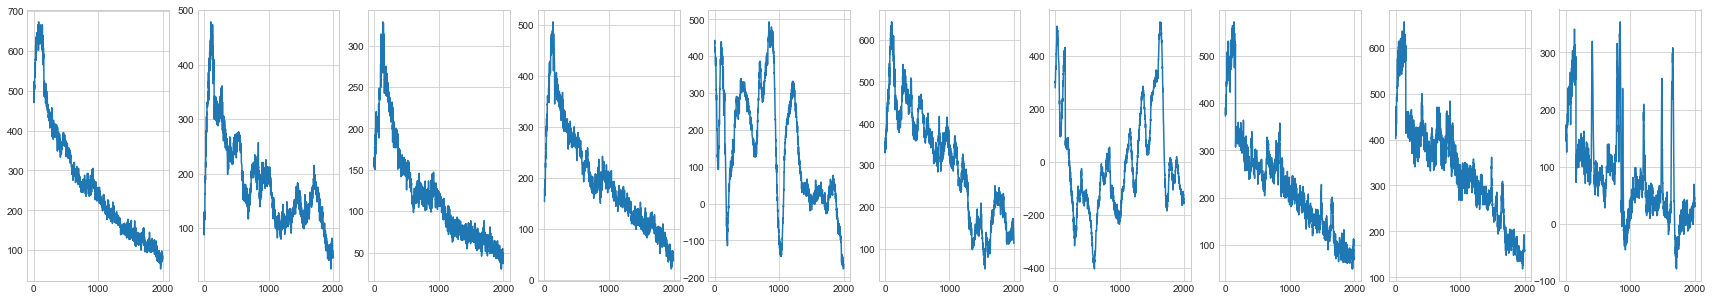

In [6]:
plot_data(input_, target2.size(0), target2)

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 9725806.544583028
0th additional RBFlayer 999th epoch MSE Loss: 3905.6503189838613
0th additional RBFlayer 1999th epoch MSE Loss: 3459.5195474381194
0th additional RBFlayer 2999th epoch MSE Loss: 3256.4030576800783
0th additional RBFlayer best loss : 3256.4030576800783


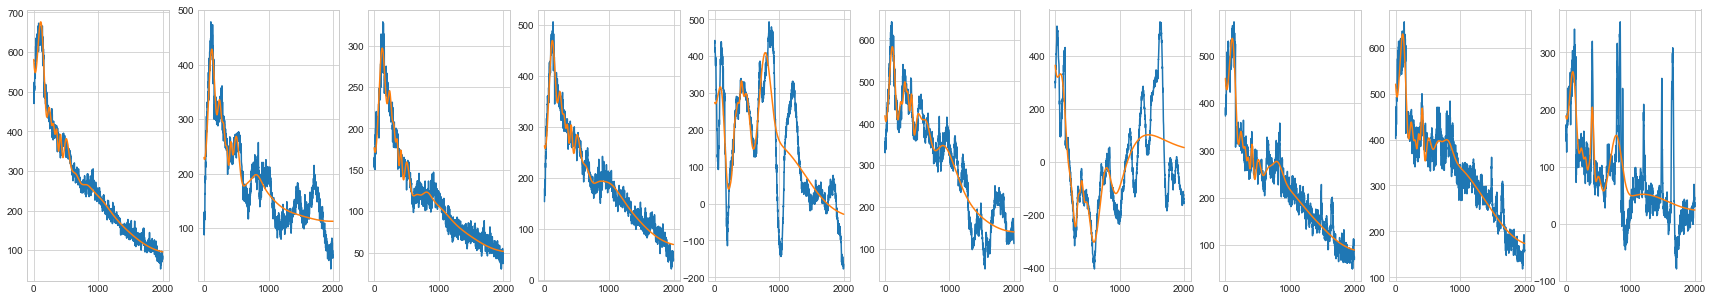

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 7737.649190395594
1th additional RBFlayer 999th epoch MSE Loss: 866.0693396006244
1th additional RBFlayer 1999th epoch MSE Loss: 752.9029859089103
1th additional RBFlayer 2999th epoch MSE Loss: 703.000960850476
1th additional RBFlayer best loss : 702.9638943552029


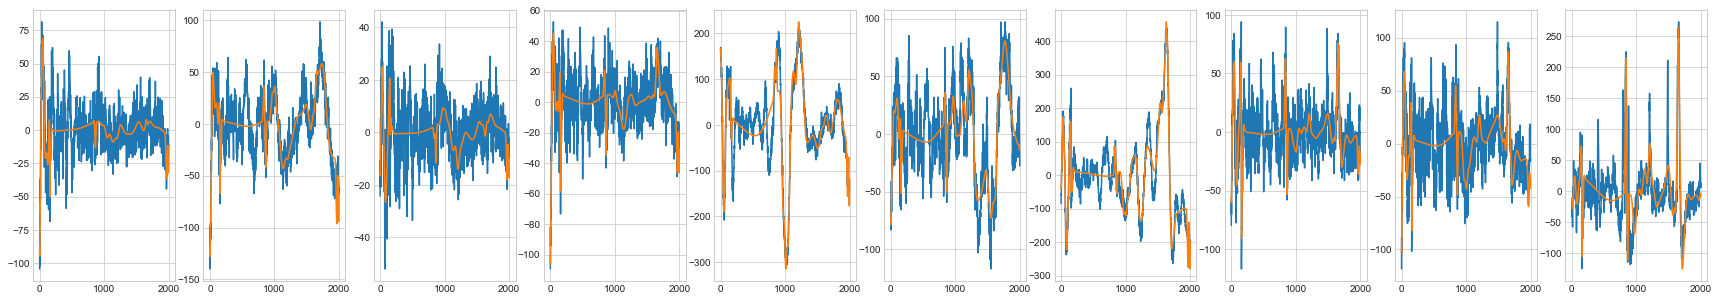

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 2645.357295710488
2th additional RBFlayer 999th epoch MSE Loss: 461.810165754308
2th additional RBFlayer 1999th epoch MSE Loss: 503.4358000052984
2th additional RBFlayer 2999th epoch MSE Loss: 439.57823166102526
2th additional RBFlayer best loss : 439.56236952938525


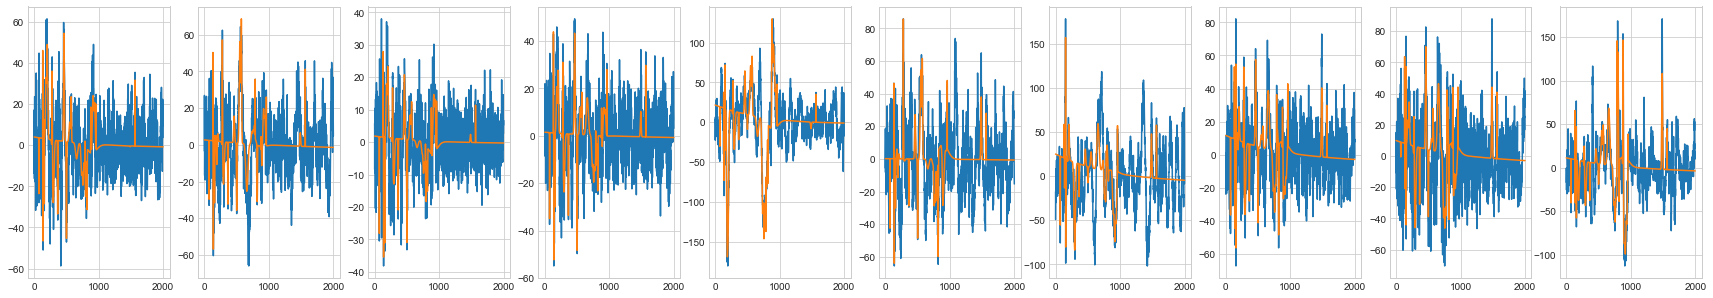

3th additional rbflayer
3th additional RBFlayer 0th epoch loss: 515.2365635051028
3th additional RBFlayer 999th epoch MSE Loss: 306.7023541050104
3th additional RBFlayer 1999th epoch MSE Loss: 292.17123733173906
3th additional RBFlayer 2999th epoch MSE Loss: 283.7888298747363
3th additional RBFlayer best loss : 283.80815346569426


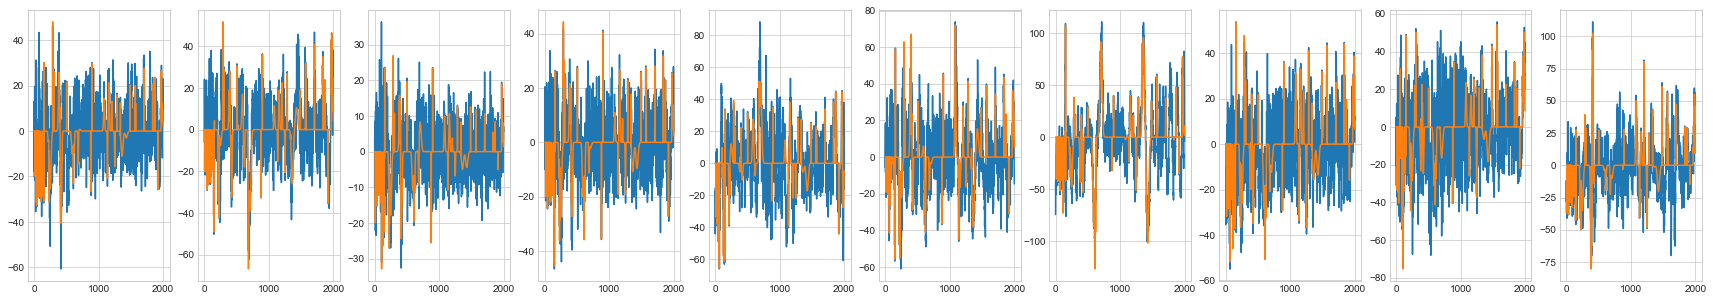

4th additional rbflayer
4th additional RBFlayer 0th epoch loss: 285.02107170295284
4th additional RBFlayer 999th epoch MSE Loss: 223.1517939059131
4th additional RBFlayer 1999th epoch MSE Loss: 219.4089087119337
4th additional RBFlayer 2999th epoch MSE Loss: 216.6103313740681
4th additional RBFlayer best loss : 216.60693240158758


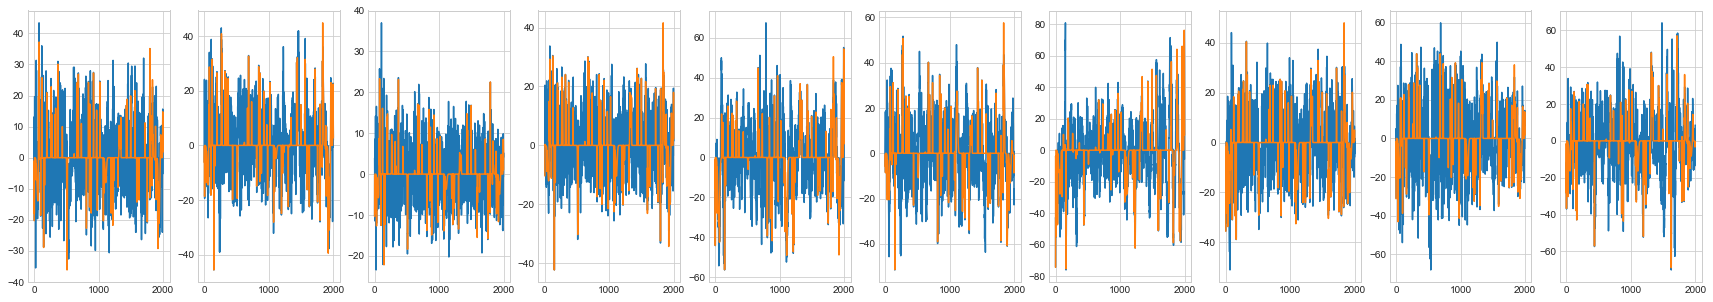

5th additional rbflayer
5th additional RBFlayer 0th epoch loss: 210.262872314989
5th additional RBFlayer 999th epoch MSE Loss: 175.8393076171267
5th additional RBFlayer 1999th epoch MSE Loss: 173.87654378115383
5th additional RBFlayer 2999th epoch MSE Loss: 172.2414541362057
5th additional RBFlayer best loss : 172.336602334369


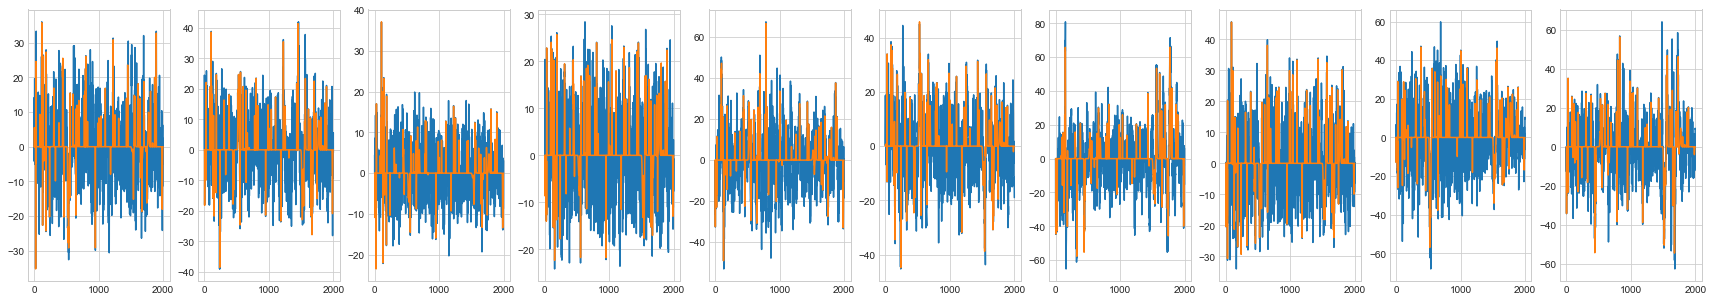

6th additional rbflayer
6th additional RBFlayer 0th epoch loss: 162.55650512168984
6th additional RBFlayer 999th epoch MSE Loss: 142.59603043362964
6th additional RBFlayer 1999th epoch MSE Loss: 141.327098801705
6th additional RBFlayer 2999th epoch MSE Loss: 141.17012772099983
6th additional RBFlayer best loss : 140.71519794606456


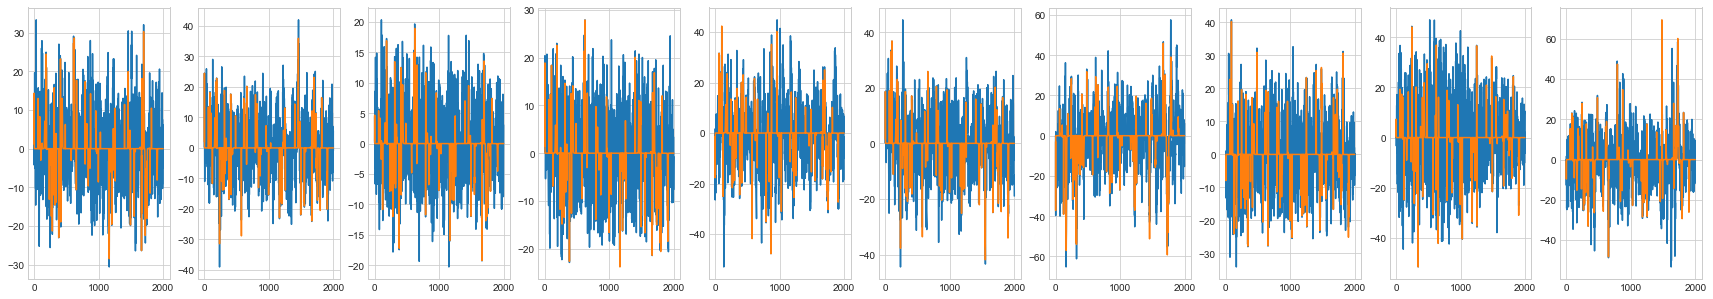

7th additional rbflayer
7th additional RBFlayer 0th epoch loss: 129.34340494739683
7th additional RBFlayer 999th epoch MSE Loss: 119.01893496397851
7th additional RBFlayer 1999th epoch MSE Loss: 118.55146906759852
7th additional RBFlayer 2999th epoch MSE Loss: 118.2741570570475
7th additional RBFlayer best loss : 117.8151360197424


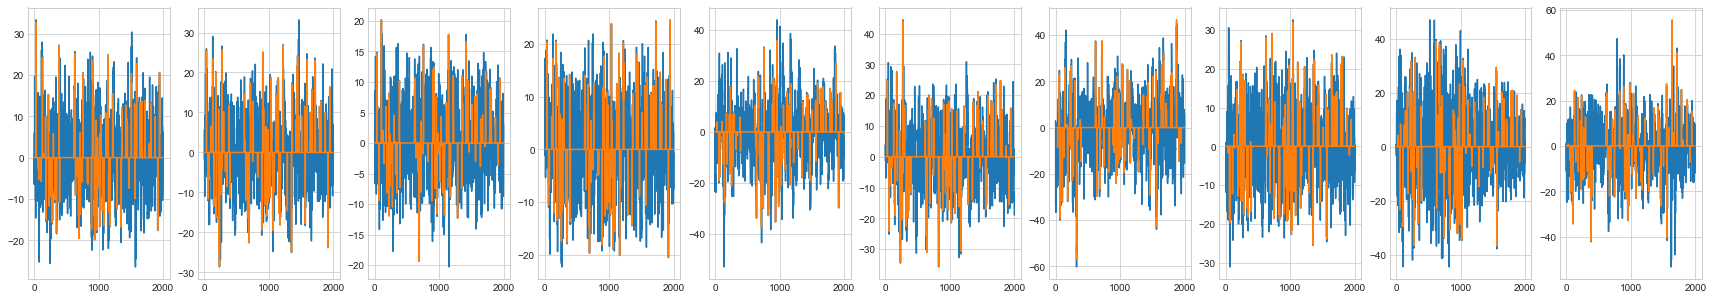

8th additional rbflayer
8th additional RBFlayer 0th epoch loss: 112.86978467693523
8th additional RBFlayer 999th epoch MSE Loss: 101.77239509769768
8th additional RBFlayer 1999th epoch MSE Loss: 101.55656931242996
8th additional RBFlayer 2999th epoch MSE Loss: 101.53034708421242
8th additional RBFlayer best loss : 101.36416555538993


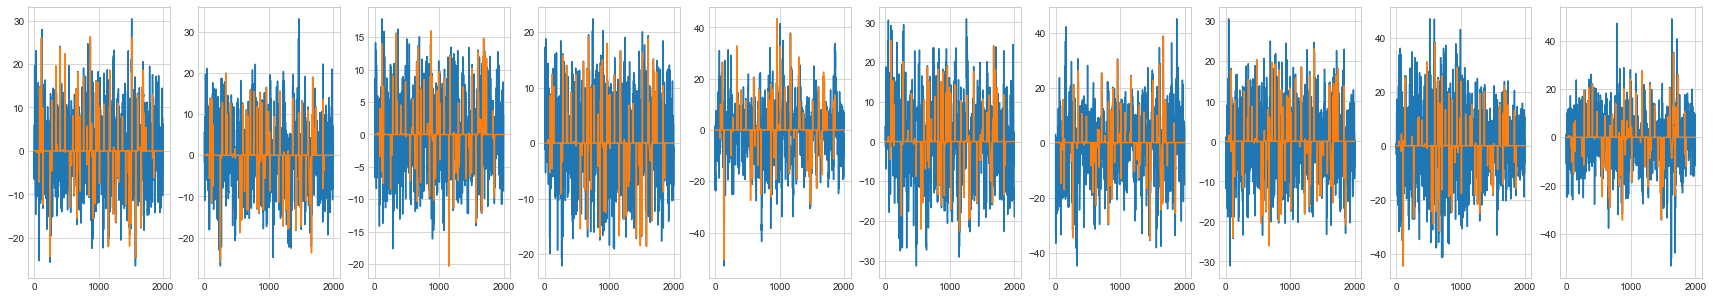

9th additional rbflayer
9th additional RBFlayer 0th epoch loss: 98.0268080787594
9th additional RBFlayer 999th epoch MSE Loss: 88.1802594835097
9th additional RBFlayer 1999th epoch MSE Loss: 88.51981564030805
9th additional RBFlayer 2999th epoch MSE Loss: 88.47235978664995
9th additional RBFlayer best loss : 87.18180785897485


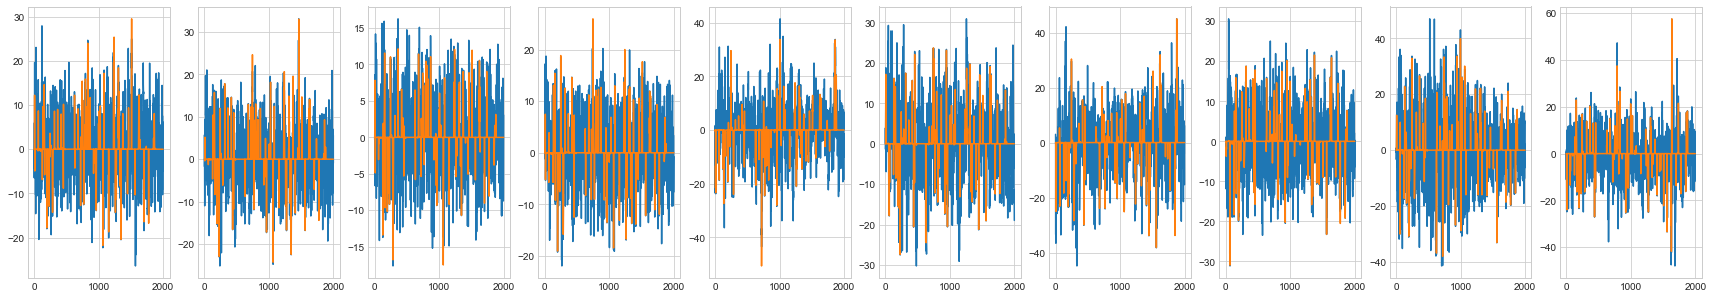

10th additional rbflayer
10th additional RBFlayer 0th epoch loss: 84.36419592181824
10th additional RBFlayer 999th epoch MSE Loss: 76.21370527000813
10th additional RBFlayer 1999th epoch MSE Loss: 76.46166807916003
10th additional RBFlayer 2999th epoch MSE Loss: 76.4302140213423
10th additional RBFlayer best loss : 75.25709106475428


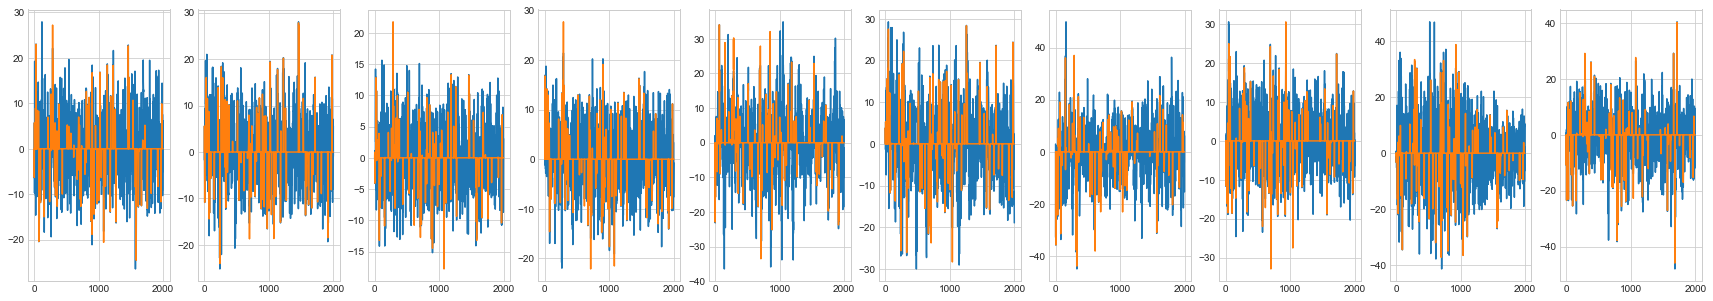

11th additional rbflayer
11th additional RBFlayer 0th epoch loss: 75.0549405583118
11th additional RBFlayer 999th epoch MSE Loss: 66.04290408179197
11th additional RBFlayer 1999th epoch MSE Loss: 65.95645369923167
11th additional RBFlayer 2999th epoch MSE Loss: 65.94525784339142
11th additional RBFlayer best loss : 65.90832641610504


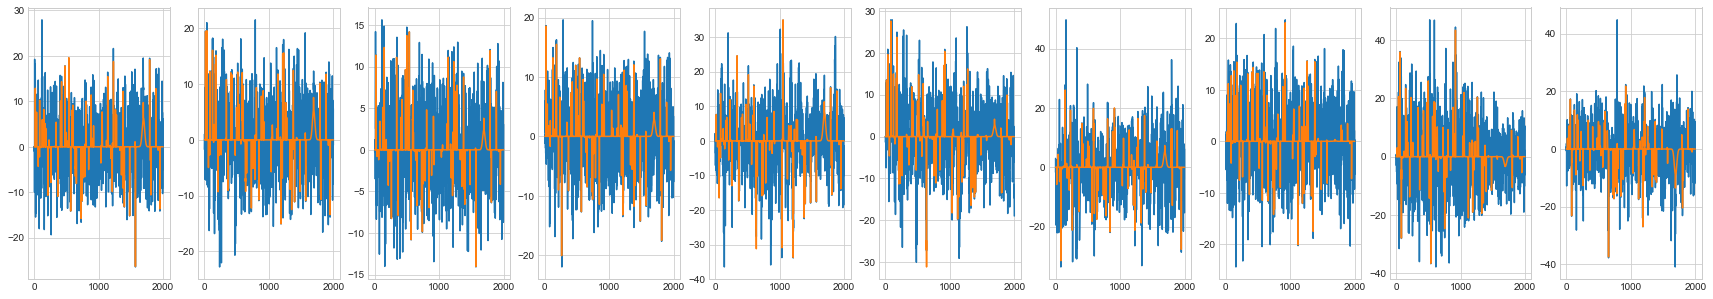

12th additional rbflayer
12th additional RBFlayer 0th epoch loss: 104.49706260443504
12th additional RBFlayer 999th epoch MSE Loss: 59.37667612270662
12th additional RBFlayer 1999th epoch MSE Loss: 59.142184195315046
12th additional RBFlayer 2999th epoch MSE Loss: 59.155147496842446
12th additional RBFlayer best loss : 59.101419062185386


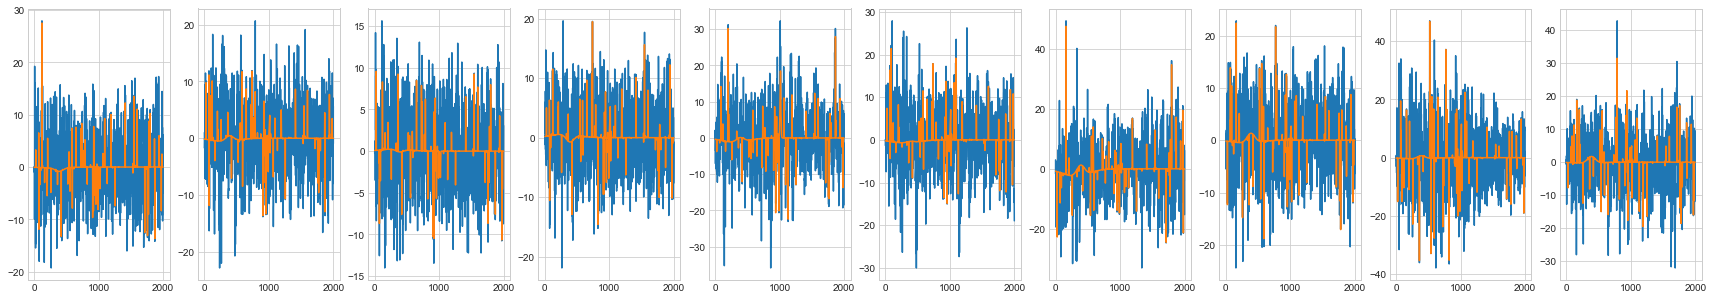

13th additional rbflayer
13th additional RBFlayer 0th epoch loss: 59.05975450059157
13th additional RBFlayer 999th epoch MSE Loss: 53.27059918488122
13th additional RBFlayer 1999th epoch MSE Loss: 53.68511228257923
13th additional RBFlayer 2999th epoch MSE Loss: 53.92381785048671
13th additional RBFlayer best loss : 52.58303637885162


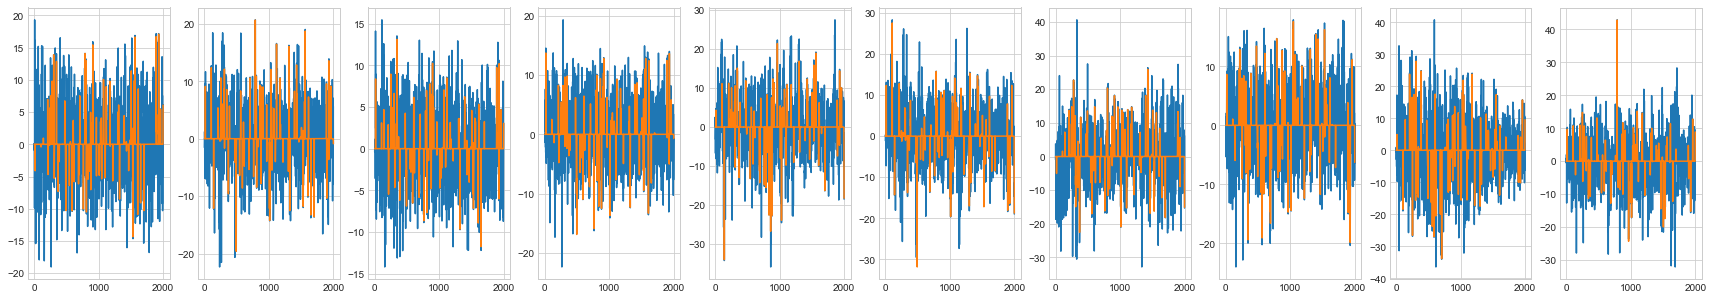

14th additional rbflayer
14th additional RBFlayer 0th epoch loss: 53.05673995502465
14th additional RBFlayer 999th epoch MSE Loss: 48.07393311357638
14th additional RBFlayer 1999th epoch MSE Loss: 48.05573272065022
14th additional RBFlayer 2999th epoch MSE Loss: 47.976745342117965
14th additional RBFlayer best loss : 47.9514558994896


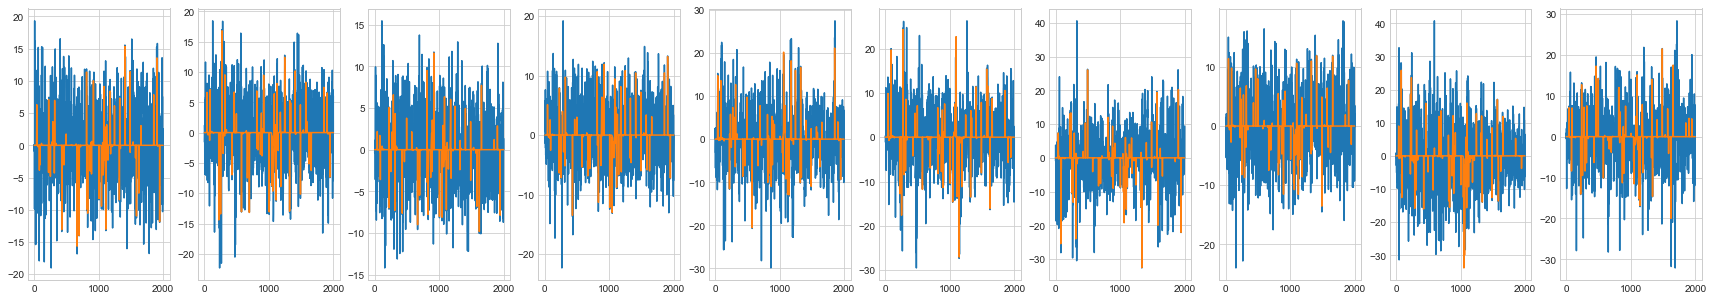

15th additional rbflayer
15th additional RBFlayer 0th epoch loss: 50.14879976445179
15th additional RBFlayer 999th epoch MSE Loss: 44.12455556788099
15th additional RBFlayer 1999th epoch MSE Loss: 44.36176030074422
15th additional RBFlayer 2999th epoch MSE Loss: 44.330881011655805
15th additional RBFlayer best loss : 44.02885422060411


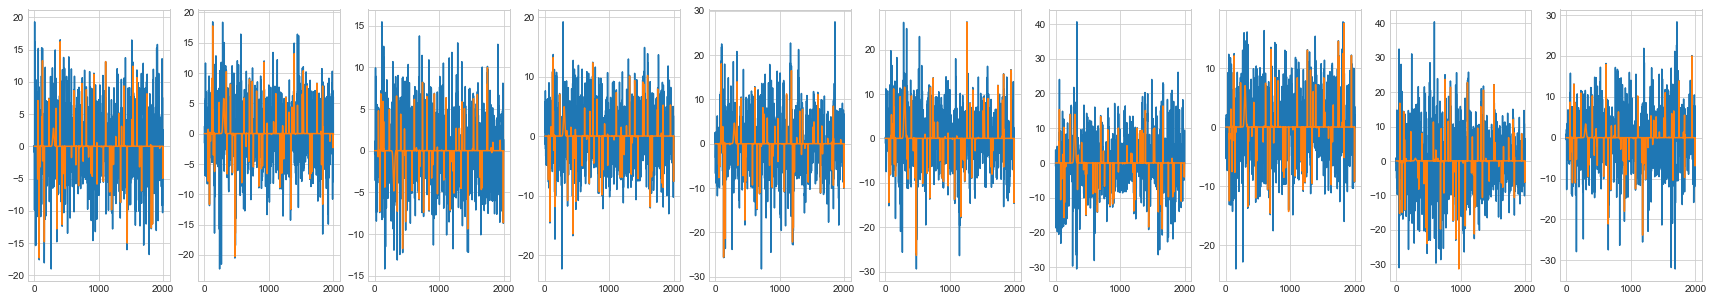

16th additional rbflayer
16th additional RBFlayer 0th epoch loss: 47.041227079982484
16th additional RBFlayer 999th epoch MSE Loss: 40.50359910831532
16th additional RBFlayer 1999th epoch MSE Loss: 40.42712897717881
16th additional RBFlayer 2999th epoch MSE Loss: 40.33565427648226
16th additional RBFlayer best loss : 40.264881974439675


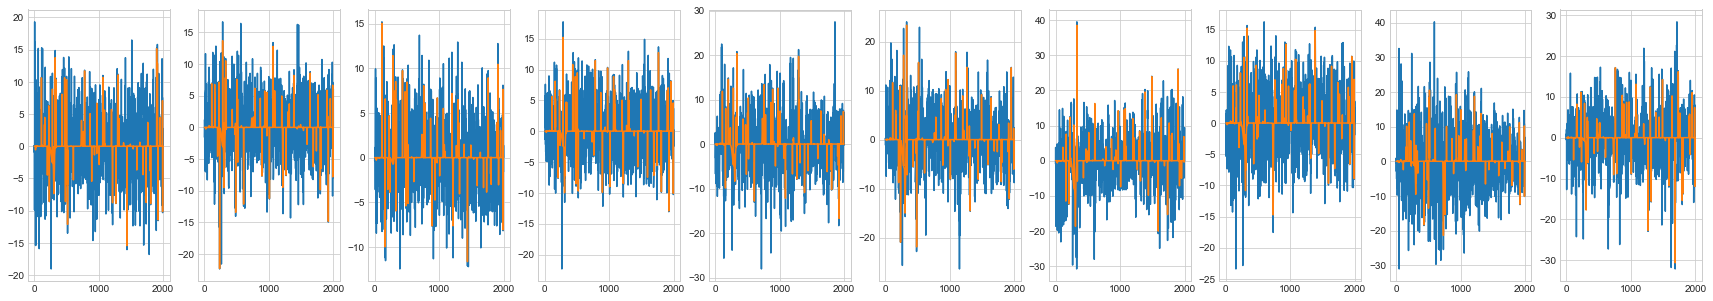

17th additional rbflayer
17th additional RBFlayer 0th epoch loss: 42.2538785273172
17th additional RBFlayer 999th epoch MSE Loss: 37.55666582543531
17th additional RBFlayer 1999th epoch MSE Loss: 37.79098116947581
17th additional RBFlayer 2999th epoch MSE Loss: 37.694650277158466
17th additional RBFlayer best loss : 37.45477373463208


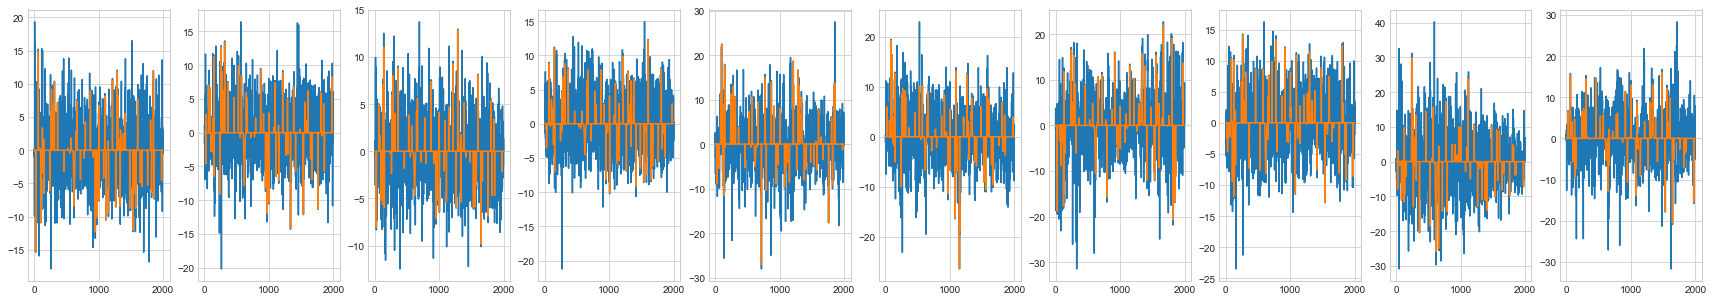

18th additional rbflayer
18th additional RBFlayer 0th epoch loss: 39.924839785036106
18th additional RBFlayer 999th epoch MSE Loss: 35.23349244634826
18th additional RBFlayer 1999th epoch MSE Loss: 34.928260703224645
18th additional RBFlayer 2999th epoch MSE Loss: 34.95269561836736
18th additional RBFlayer best loss : 34.926846682139676


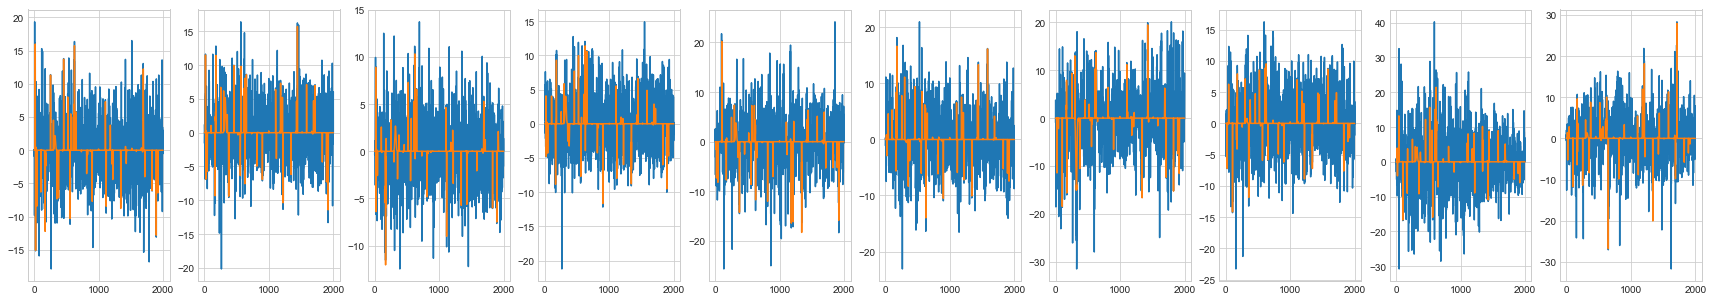

19th additional rbflayer
19th additional RBFlayer 0th epoch loss: 42.28309632383153
19th additional RBFlayer 999th epoch MSE Loss: 34.17767024147211
19th additional RBFlayer 1999th epoch MSE Loss: 33.37307718629088
19th additional RBFlayer 2999th epoch MSE Loss: 33.1801270002905
19th additional RBFlayer best loss : 33.1801270002905


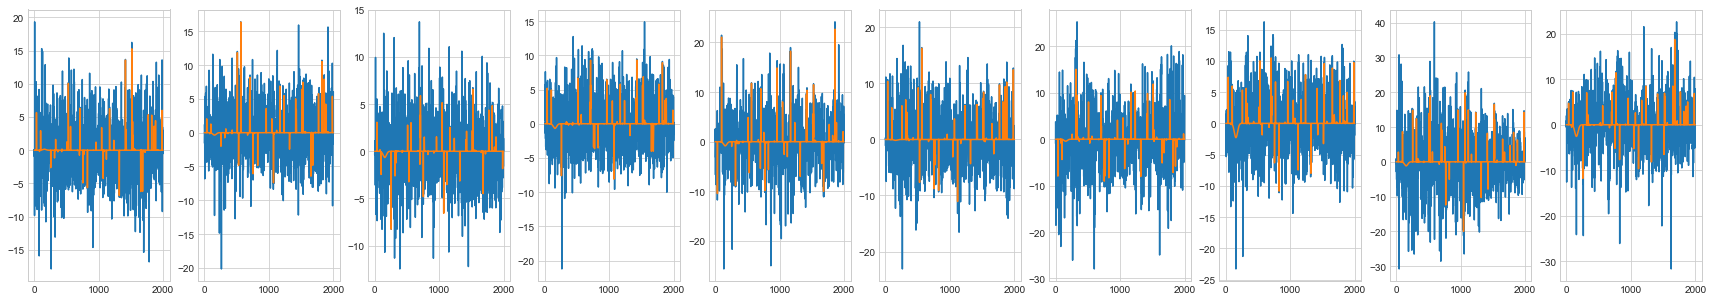

20th additional rbflayer
20th additional RBFlayer 0th epoch loss: 41.67731764333252
20th additional RBFlayer 999th epoch MSE Loss: 32.237792304913995
20th additional RBFlayer 1999th epoch MSE Loss: 31.76495527230761
20th additional RBFlayer 2999th epoch MSE Loss: 31.837754273690962
20th additional RBFlayer best loss : 31.729246979555995


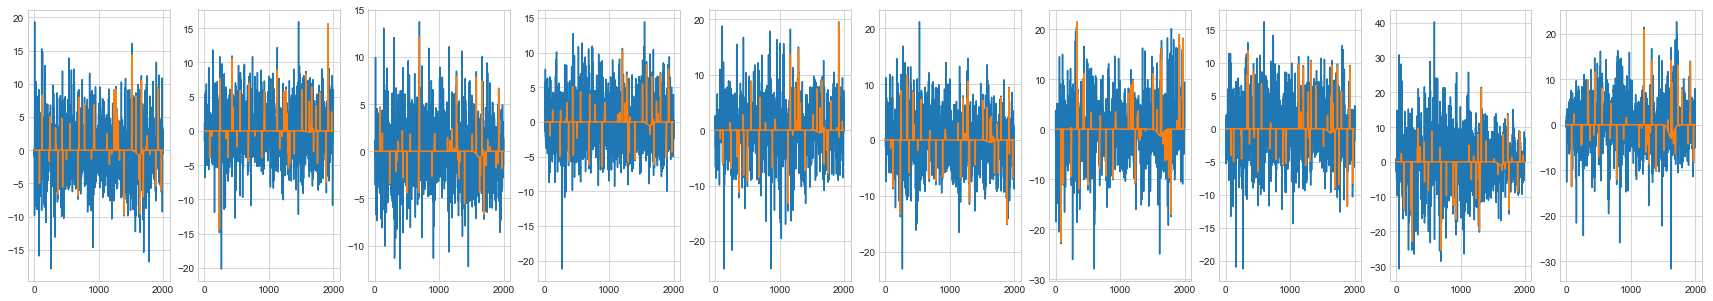

21th additional rbflayer
21th additional RBFlayer 0th epoch loss: 34.16195697899111
21th additional RBFlayer 999th epoch MSE Loss: 29.936392982707627
21th additional RBFlayer 1999th epoch MSE Loss: 30.25950298279205
21th additional RBFlayer 2999th epoch MSE Loss: 30.295941470485158
21th additional RBFlayer best loss : 29.862318994239743


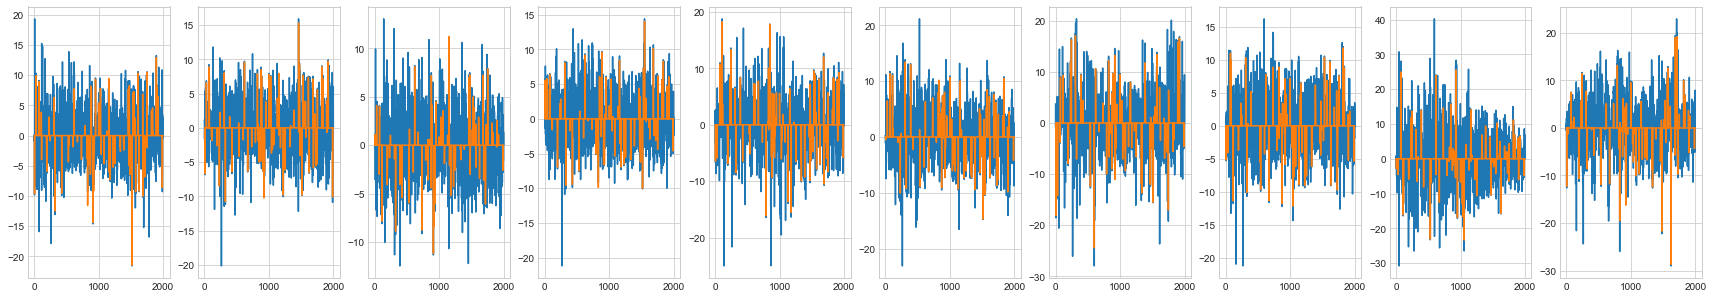

22th additional rbflayer
22th additional RBFlayer 0th epoch loss: 33.39735366427151
22th additional RBFlayer 999th epoch MSE Loss: 27.873970855444636
22th additional RBFlayer 1999th epoch MSE Loss: 27.540287739428152
22th additional RBFlayer 2999th epoch MSE Loss: 27.5942698732584
22th additional RBFlayer best loss : 27.539886645983415


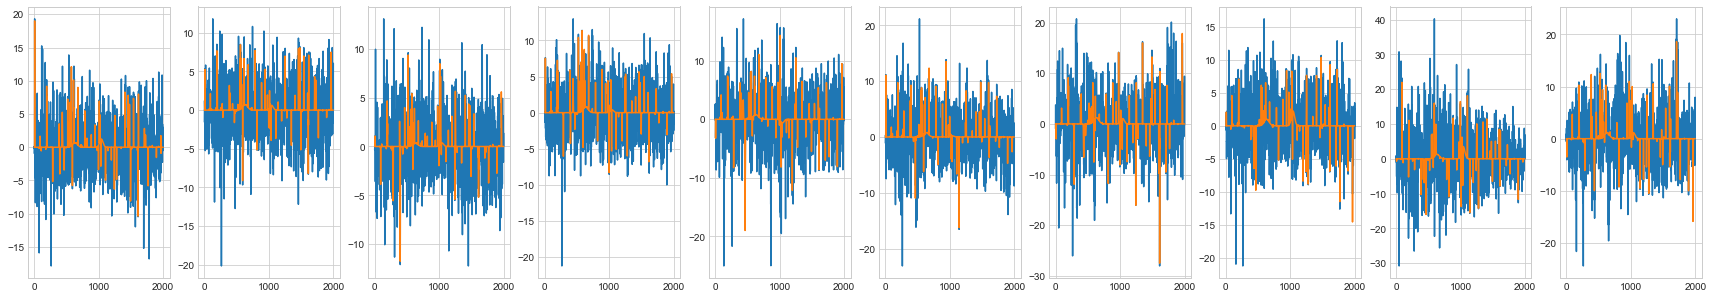

23th additional rbflayer
23th additional RBFlayer 0th epoch loss: 33.339930522907856
23th additional RBFlayer 999th epoch MSE Loss: 26.21352600504034
23th additional RBFlayer 1999th epoch MSE Loss: 26.13298132905066
23th additional RBFlayer 2999th epoch MSE Loss: 26.24219641891157
23th additional RBFlayer best loss : 26.12626516024474


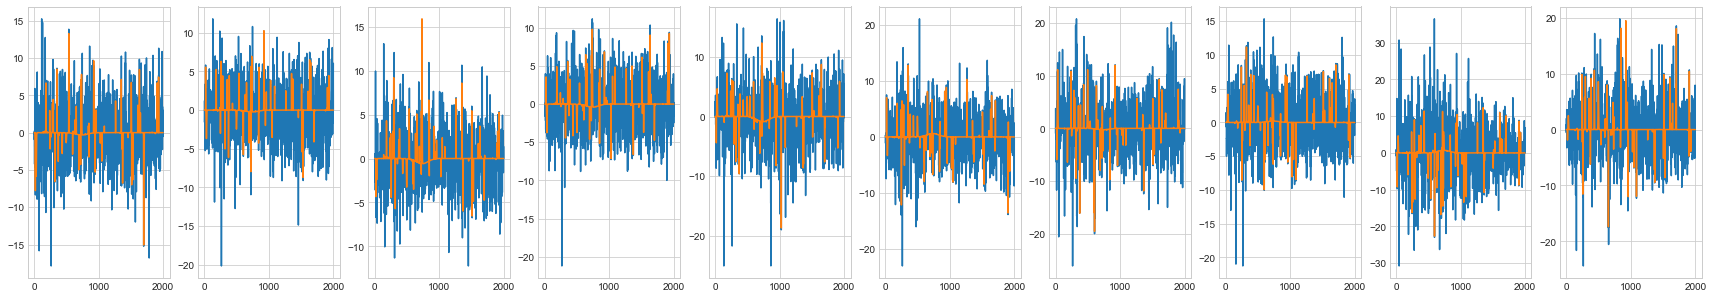

24th additional rbflayer
24th additional RBFlayer 0th epoch loss: 36.1129757115029
24th additional RBFlayer 999th epoch MSE Loss: 25.874960921802177
24th additional RBFlayer 1999th epoch MSE Loss: 25.208635193158756
24th additional RBFlayer 2999th epoch MSE Loss: 25.114785420141523
24th additional RBFlayer best loss : 25.114645455090947


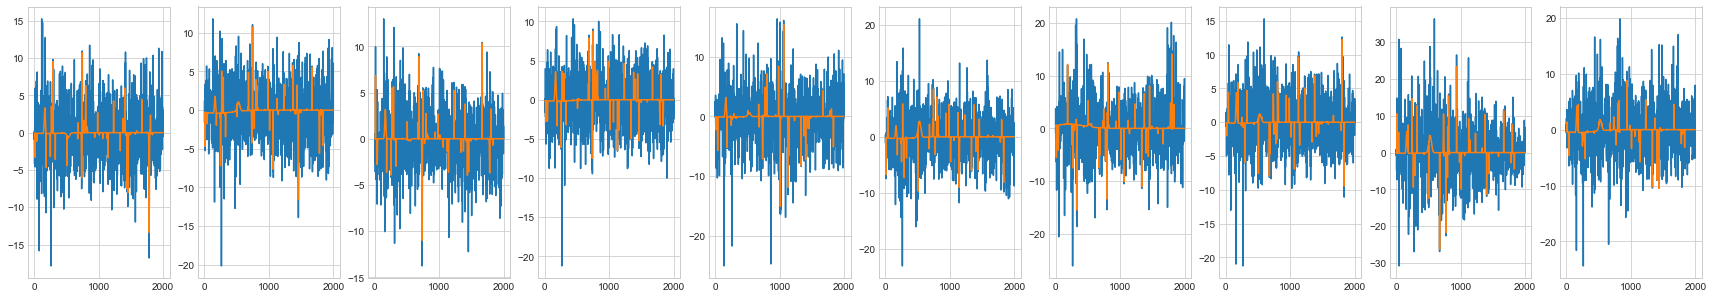

25th additional rbflayer
25th additional RBFlayer 0th epoch loss: 28.258721118360004
25th additional RBFlayer 999th epoch MSE Loss: 24.179400666701103
25th additional RBFlayer 1999th epoch MSE Loss: 23.987489372252163
25th additional RBFlayer 2999th epoch MSE Loss: 23.9019258181411
25th additional RBFlayer best loss : 23.901712642540925


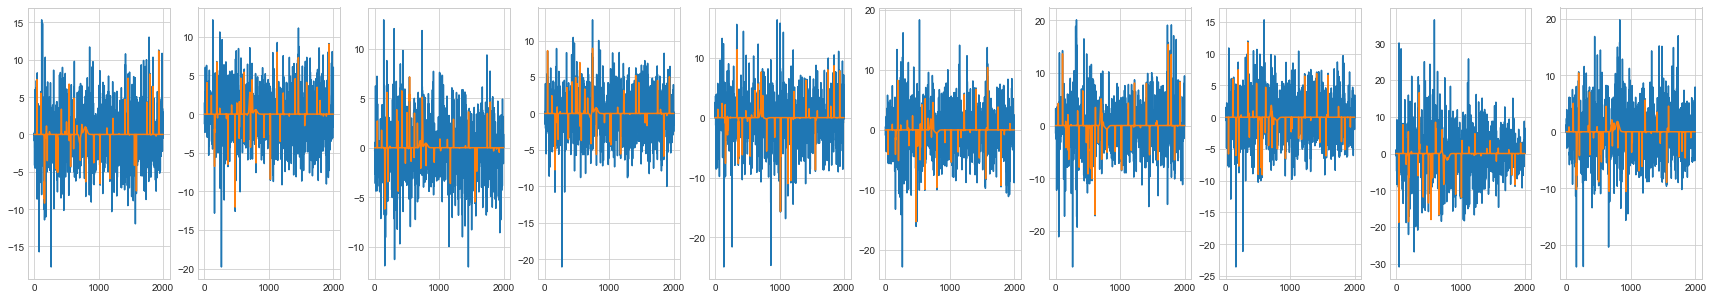

26th additional rbflayer
26th additional RBFlayer 0th epoch loss: 26.842794363272926
26th additional RBFlayer 999th epoch MSE Loss: 23.573439751499297
26th additional RBFlayer 1999th epoch MSE Loss: 23.373866825992256
26th additional RBFlayer 2999th epoch MSE Loss: 23.179752681343004
26th additional RBFlayer best loss : 23.179616277451238


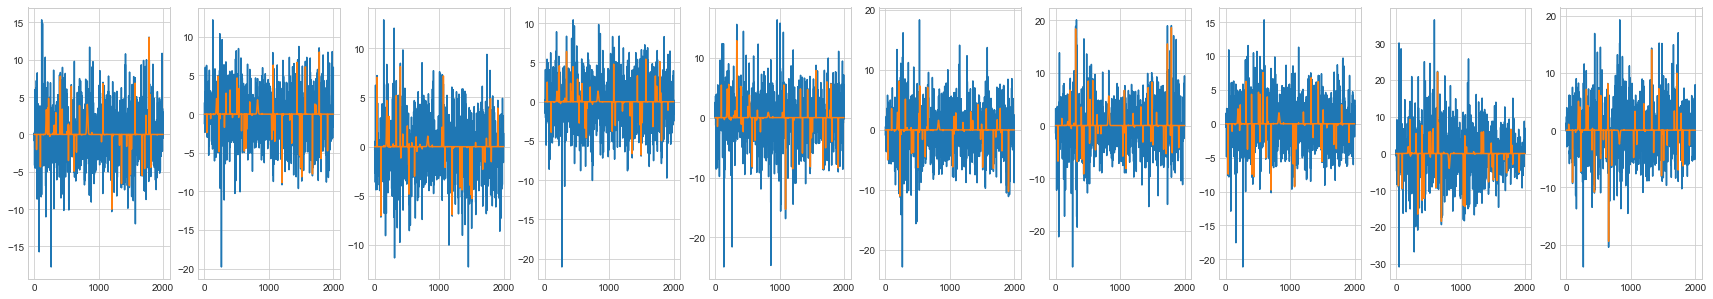

27th additional rbflayer
27th additional RBFlayer 0th epoch loss: 25.445339454512265
27th additional RBFlayer 999th epoch MSE Loss: 22.413428836479337
27th additional RBFlayer 1999th epoch MSE Loss: 22.184852950989793
27th additional RBFlayer 2999th epoch MSE Loss: 22.2042806767828
27th additional RBFlayer best loss : 22.153100417733928


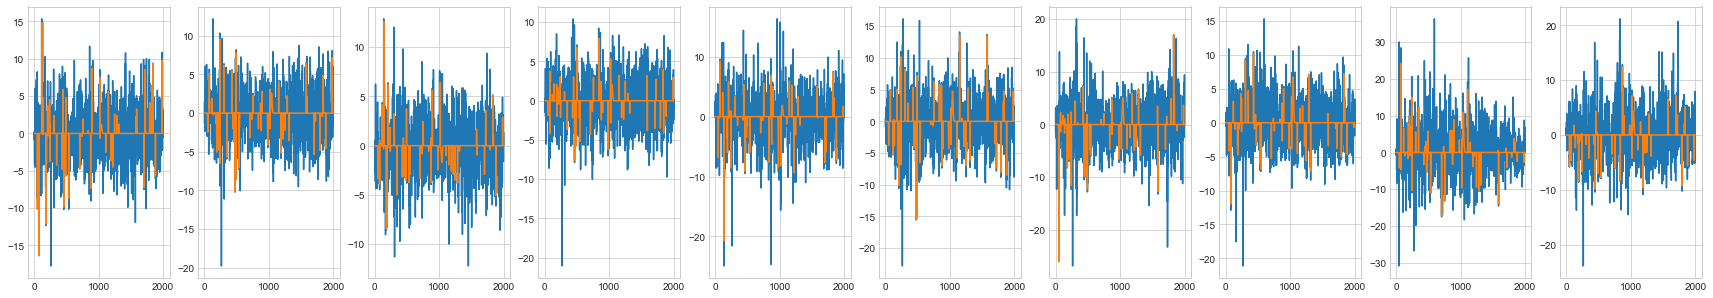

28th additional rbflayer
28th additional RBFlayer 0th epoch loss: 25.063662069743728
28th additional RBFlayer 999th epoch MSE Loss: 21.71063535807663
28th additional RBFlayer 1999th epoch MSE Loss: 21.265400594572423
28th additional RBFlayer 2999th epoch MSE Loss: 21.146437838858223
28th additional RBFlayer best loss : 21.114676900894725


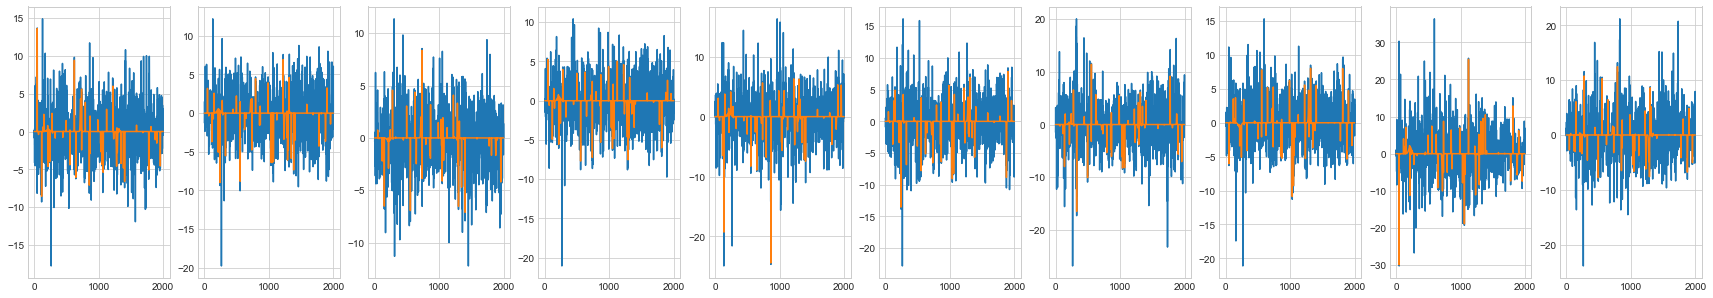

29th additional rbflayer
29th additional RBFlayer 0th epoch loss: 23.895868830737573
29th additional RBFlayer 999th epoch MSE Loss: 21.328958868525007
29th additional RBFlayer 1999th epoch MSE Loss: 20.547103772356806
29th additional RBFlayer 2999th epoch MSE Loss: 20.478284565024026
29th additional RBFlayer best loss : 20.453425814759562


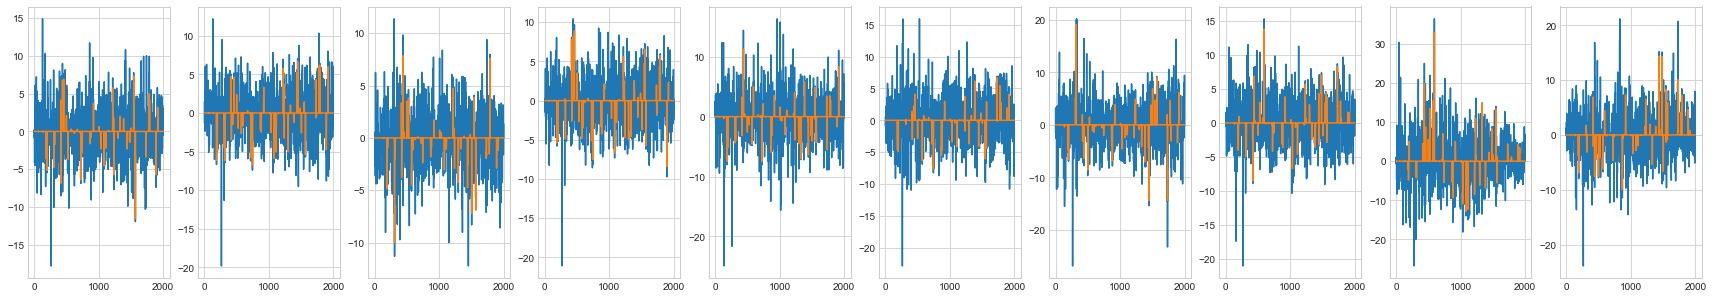

30th additional rbflayer
30th additional RBFlayer 0th epoch loss: 22.9460696742505
30th additional RBFlayer 999th epoch MSE Loss: 20.332784406859655
30th additional RBFlayer 1999th epoch MSE Loss: 19.8491805713232
30th additional RBFlayer 2999th epoch MSE Loss: 19.745555454486173
30th additional RBFlayer best loss : 19.74547894599927
change lr  0.0001
----------------------------------------------


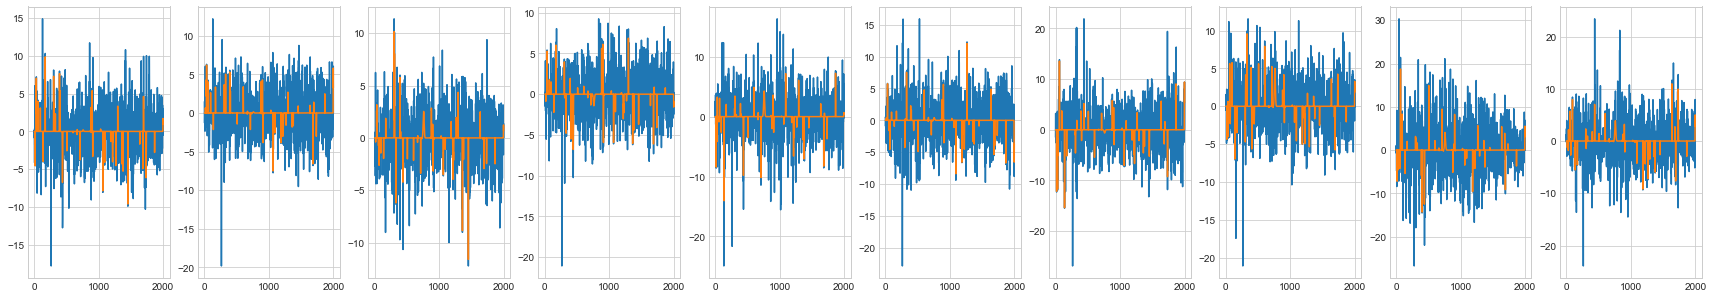

In [7]:
model_eeg1 = MultiRBFnn(target2.size(0), 100, device)
model_eeg1.train(input_, target2, 3000, 0.00001, 20, 20)

<Figure size 2160x720 with 0 Axes>

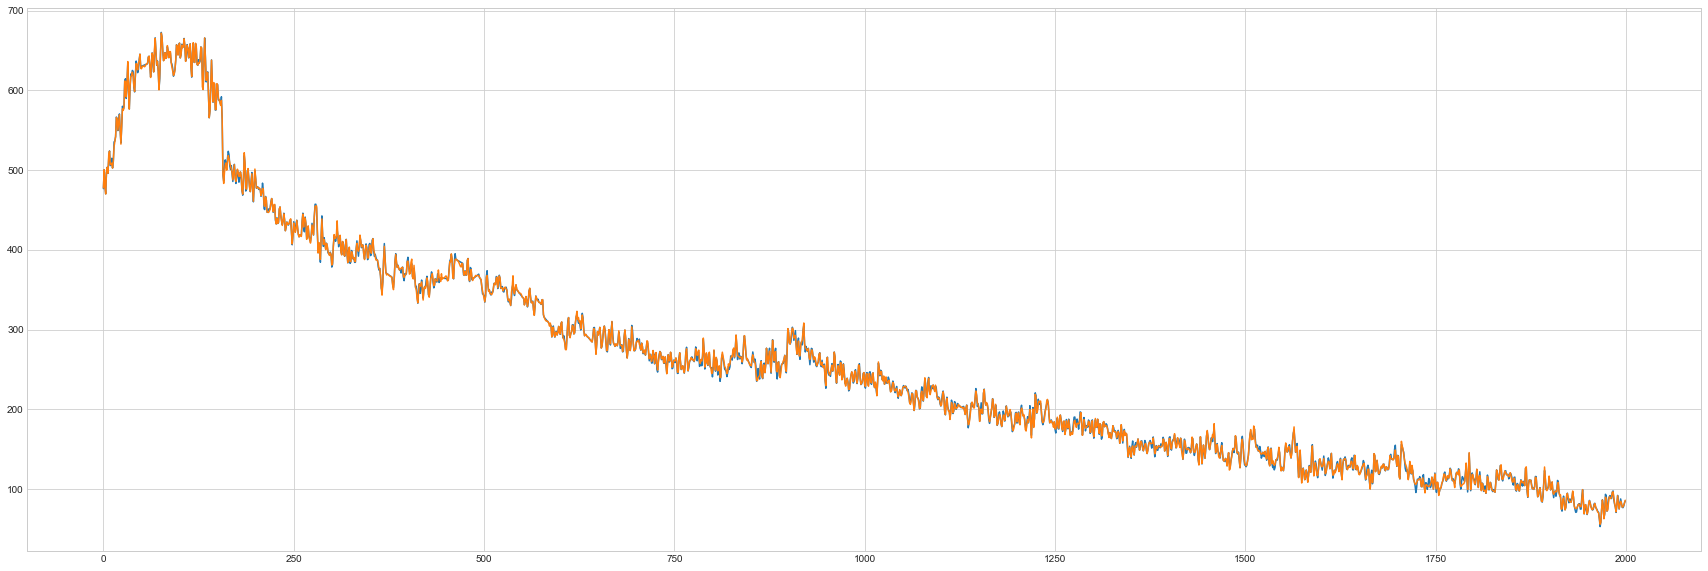

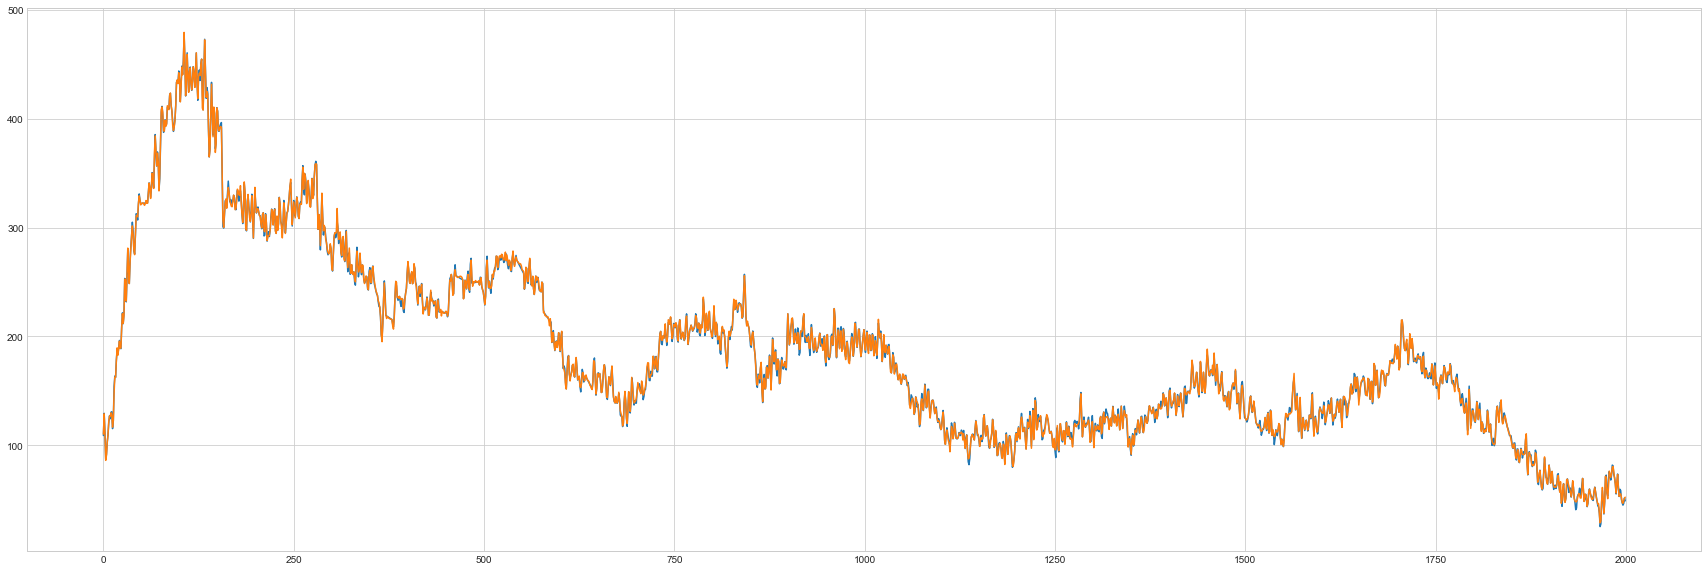

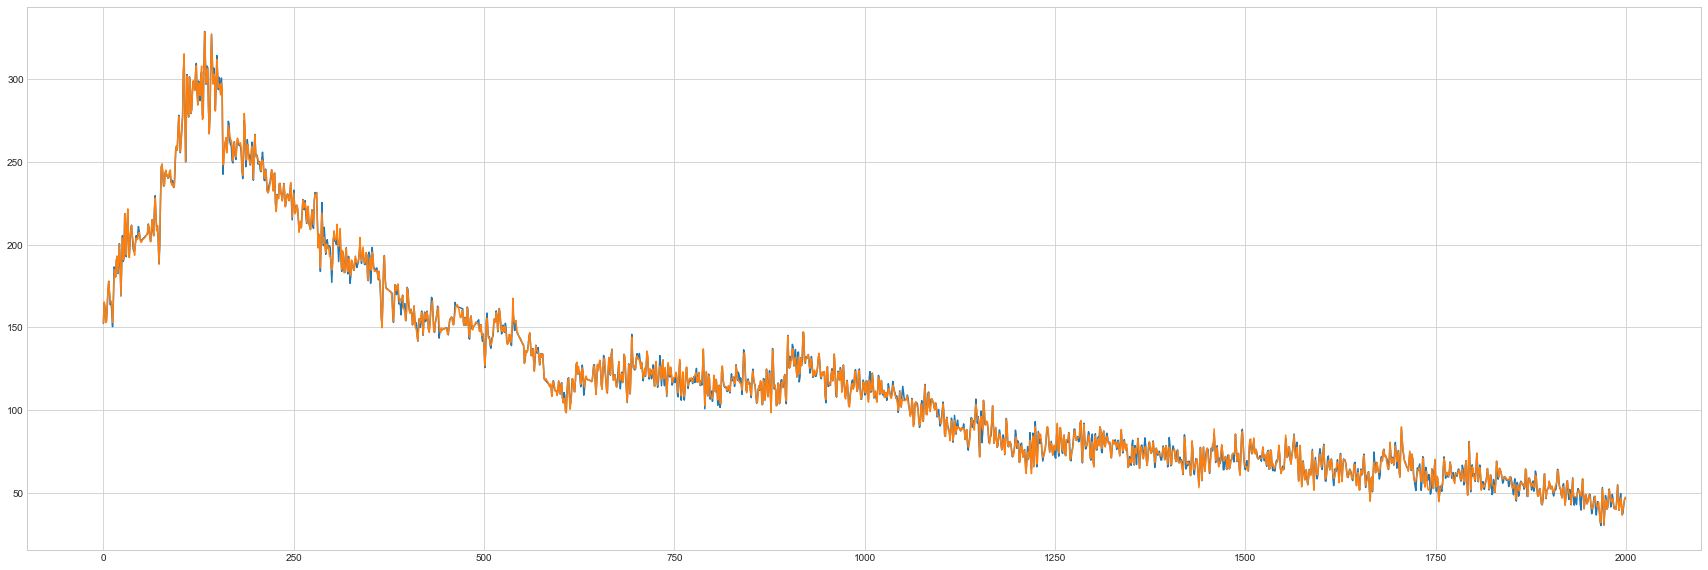

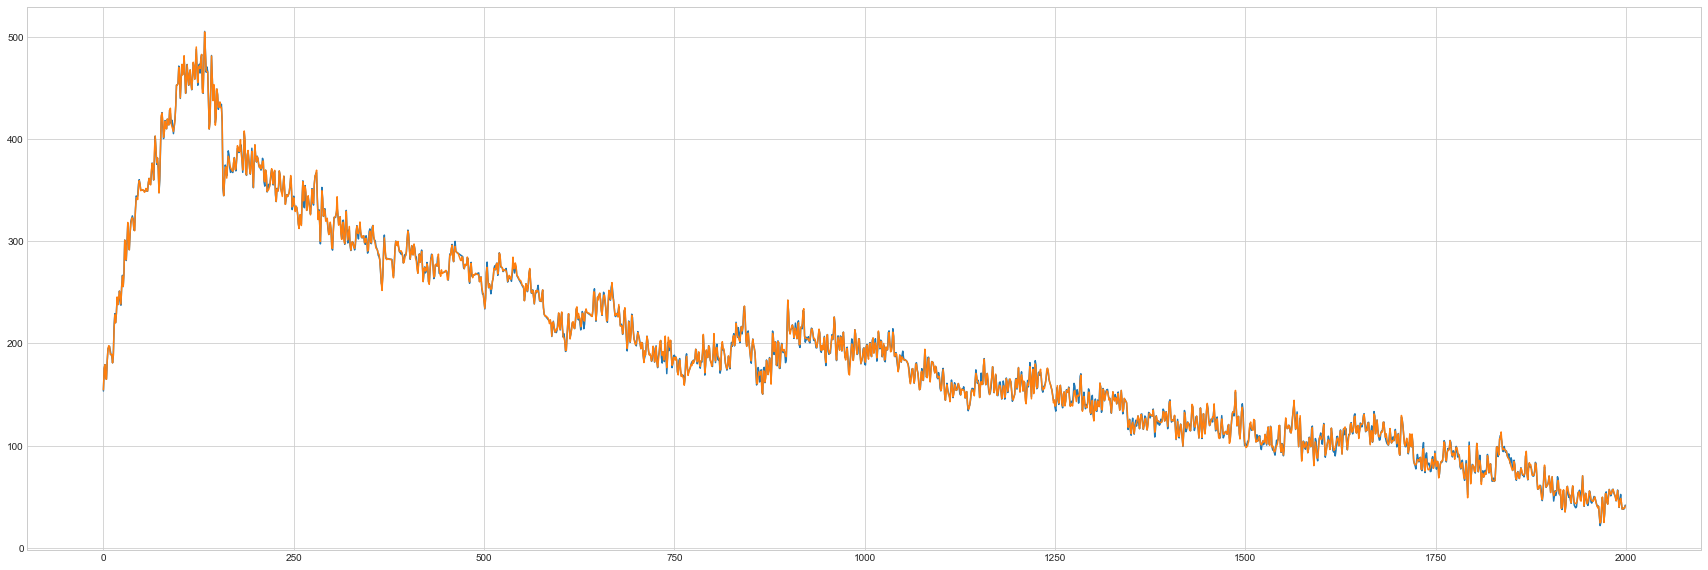

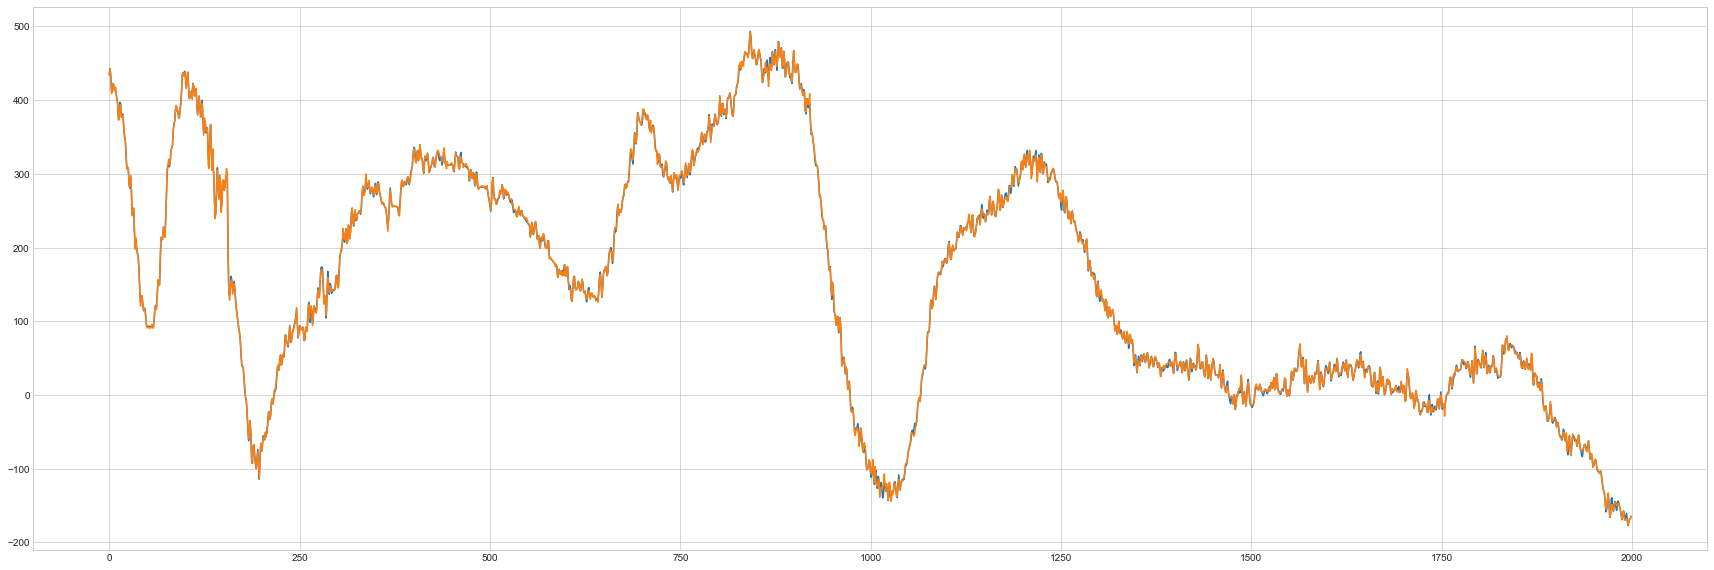

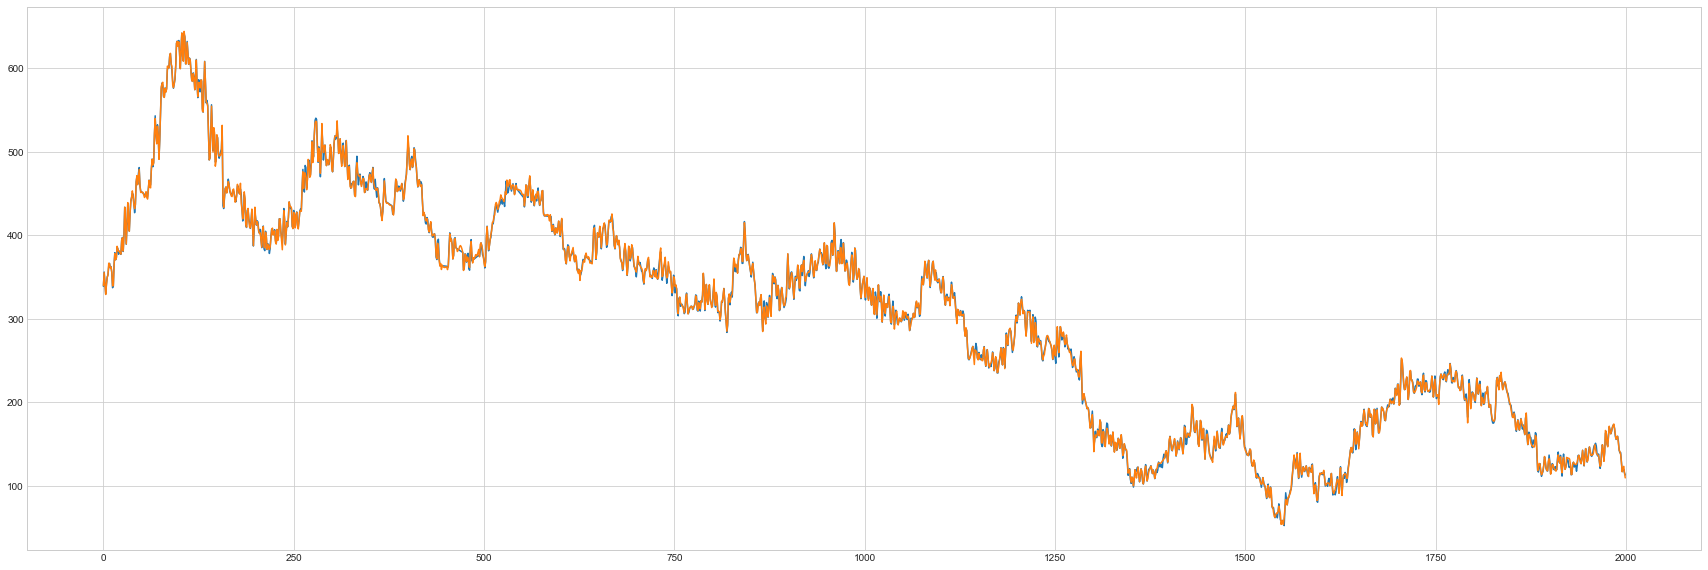

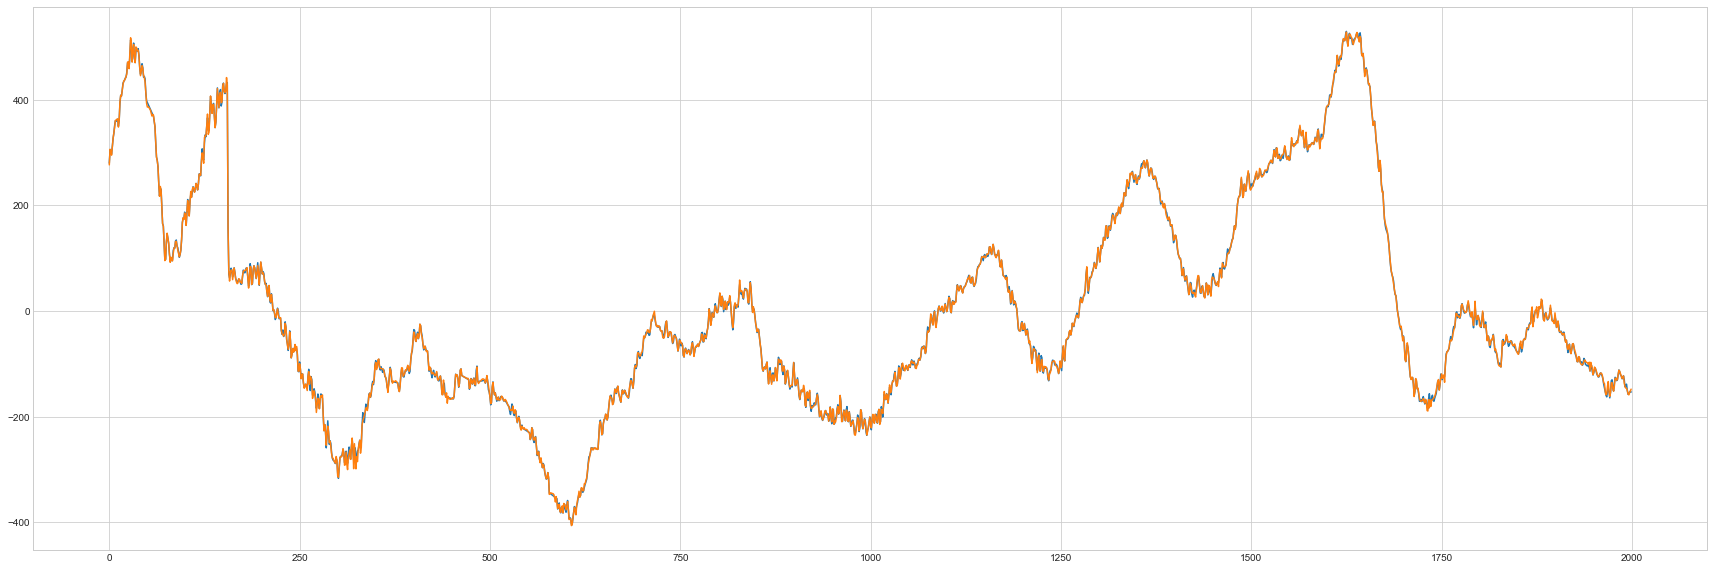

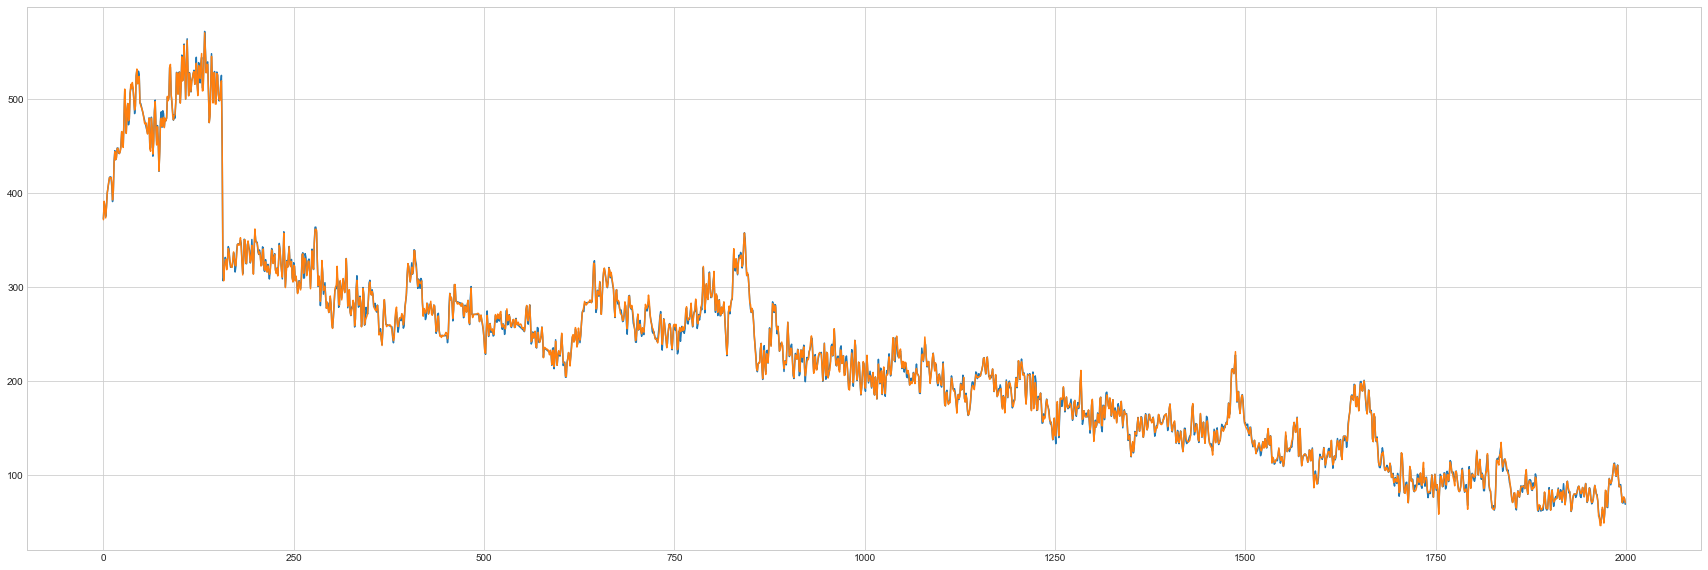

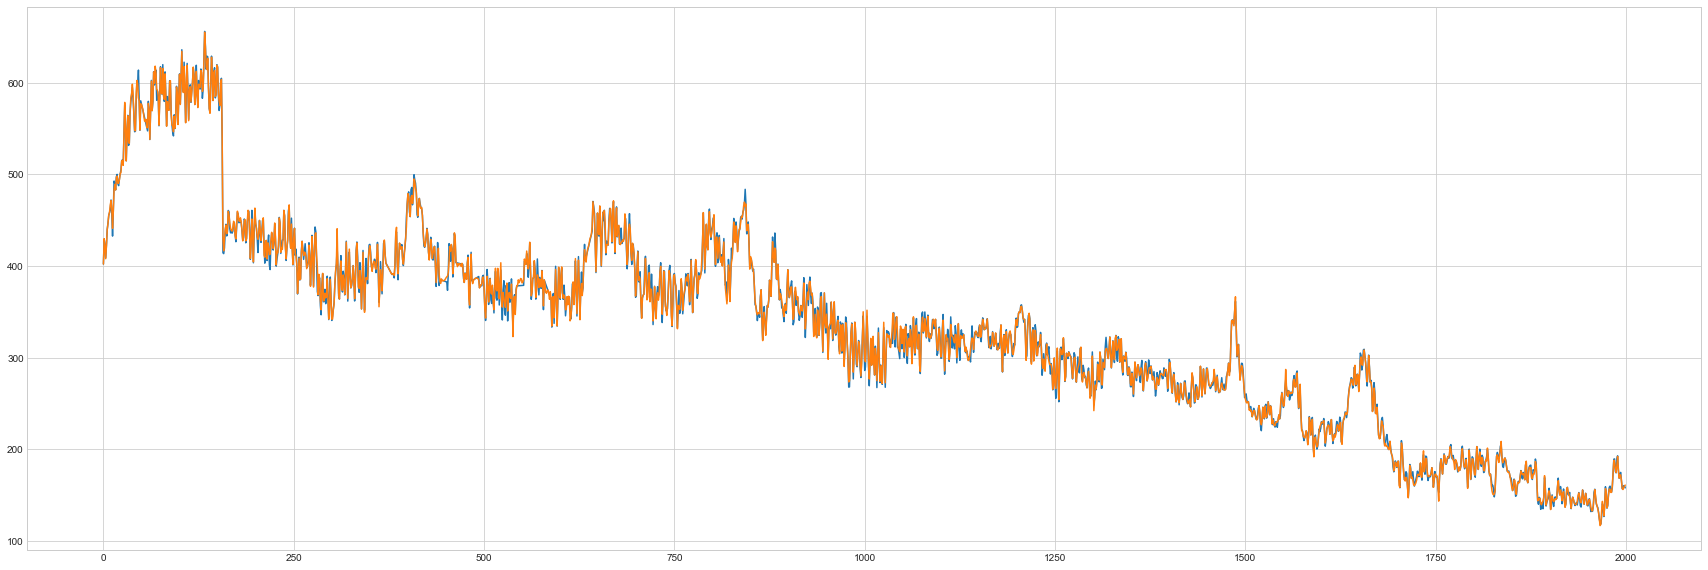

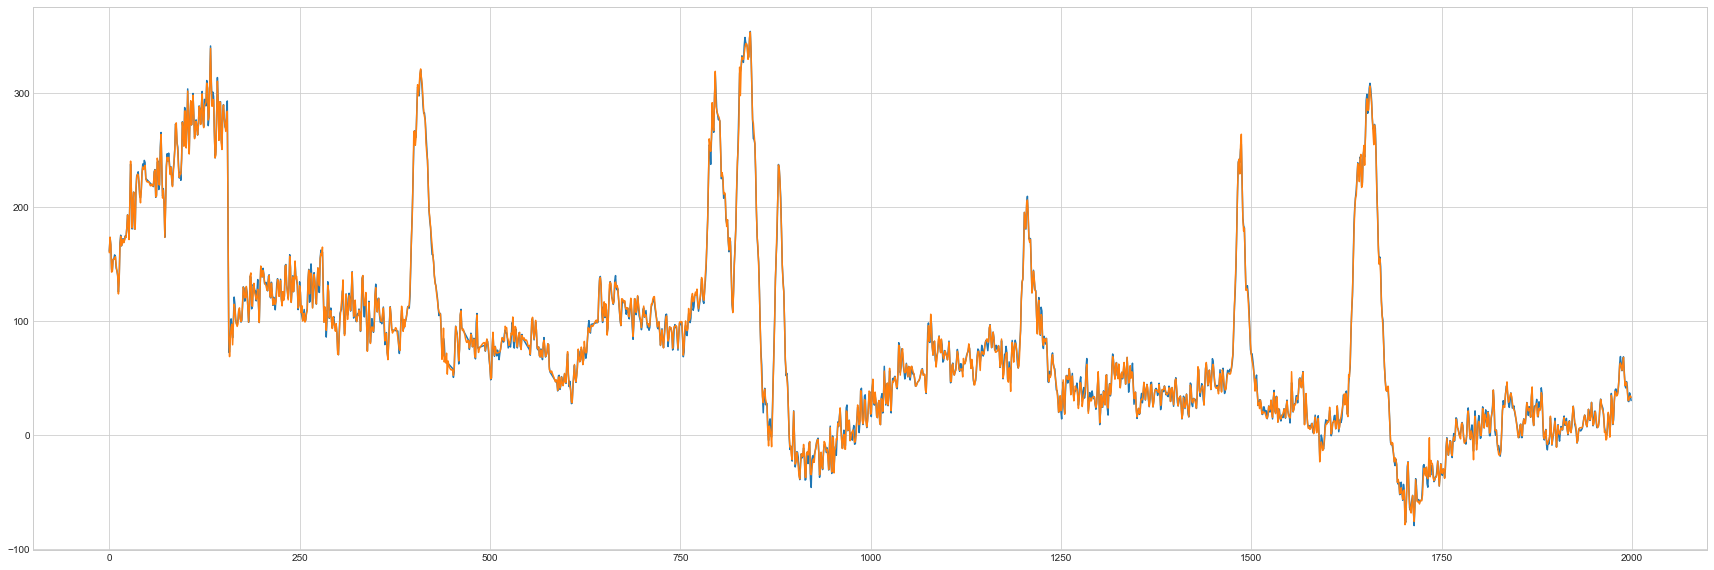

In [8]:
plt.figure(figsize=(30, 10))
model_pred = model_eeg1.pred(input_)[1]
for i in range(target2.size(0)):
    plt.figure(figsize=(30, 10))
    plt.plot(input_.cpu().detach().numpy(), target2[i].cpu().detach().numpy())
    plt.plot(input_.cpu().detach().numpy(), model_pred[i].cpu().detach().numpy())
    plt.show()

In [22]:
import mmcv

c:\Users\chanyoung\anaconda3\envs\cooling\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


# PSO algorithm

In [23]:
class PSO_update(nn.Module):
    def __init__(self, input_data, linear_weights, centers, sigmas, particle_num, device):
        super(PSO_update, self).__init__()
        
        self.input_data = input_data          # (num_data)
        self.linear_weights = linear_weights  # (num_feature, num_rbf) -> train
        self.centers = centers                # (num_rbf, 1)
        self.sigmas = sigmas                  # (num_rbf, 1)
        self.device = device
        self.particle_num = particle_num
        
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        torch.cuda.manual_seed_all(0)

    def rbf_gaussian(self): # done
        out = torch.exp(-1 *(torch.pow((self.input_data - self.centers), 2)) / (torch.pow(self.sigmas, 2)))

        return out
        
    def rbfnn(self, weights): # done
        R = self.rbf_gaussian()
        output = torch.mm(weights, R)

        return output  # size = (num_feature, num_rbf)
    
    def rbf_gradient(self): # done
        rbf_output = (-2 * (self.input_data - self.centers) / torch.pow(self.sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((self.input_data - self.centers), 2) / (torch.pow(self.sigmas, 2)))))
        # rbf_grad = torch.mm(weights, rbf_output)
        return rbf_output
    
    def particle_gradient(self, particle): # done
        rbf_output = self.rbf_gradient()
        rbf_grad = torch.mm(particle, rbf_output)
        
        return rbf_grad
    
    # fitness_function
    def cost_function(self, weights,  target, true_grad): #done
        pred = self.rbfnn(weights)
        pred_grad = self.particle_gradient(weights)
        error = torch.mean(torch.pow(target - pred, 2) + torch.pow(true_grad-pred_grad, 2))
        #error = torch.cov(pred) - torch.cov(target)
        return error
    
    def update_position(self, particle, velocity):
        new_particle = particle + velocity
        
        return new_particle
    
    def target_grad(self, target): # done
        space = (self.input_data,)
        for i in range(target.size(0)):
            if i == 0:
                f_grad = torch.gradient(target[i], spacing = space, edge_order  = 1)[0]
            else:
                f_grad = torch.vstack([f_grad, torch.gradient(target[i], spacing = space, edge_order  = 1)[0]])
        return f_grad
    
    def inertia_weight(self, particles, target, gbest, epoch, true_grad):
        fitness = torch.tensor([self.cost_function(particles[i], target, true_grad) for i in range(self.particle_num)],
                                     device= self.device)
        
        diversity  = torch.min(fitness) / torch.max(fitness)
        gamma = torch.pow(10 - diversity, -epoch)

        A_i = self.cost_function(gbest[0], target, true_grad) / fitness
        
        return gamma*(A_i + 2).reshape(self.particle_num,1,1)
        
    def update_velocity(self, particle, velocity, pbest, gbest, inertia_weight, lr):

        r1 = lr 
        r2 = lr * 10
        new_velocity =  inertia_weight * velocity + r1 * (pbest-particle) + r2 * (gbest-particle)
        
        return new_velocity
    
    def train(self, target, epochs, loss_th, lr):
        true_grad = self.target_grad(target)
        particles = self.linear_weights.expand(self.particle_num, self.linear_weights.size(0), self.linear_weights.size(1)) - torch.randn((1000, self.linear_weights.size(0), self.linear_weights.size(1)), dtype = float, device = self.device)
        velocity = torch.randn((1000, self.linear_weights.size(0), self.linear_weights.size(1)), dtype = float, device = self.device)
        pbest_position = particles # (100, 1, rbf_num)
        pbest_fitness = torch.tensor([self.cost_function(particles[i], target, true_grad) for i in range(self.particle_num)],
                                     device= self.device)
        
        gbest_index = torch.argmin(pbest_fitness) 
        gbest = pbest_position[gbest_index].expand(self.particle_num, self.linear_weights.size(0), self.linear_weights.size(1)) # (1, rbf_num)
        prog_bar = mmcv.ProgressBar(epochs)
        loss = self.cost_function(gbest[0], target, true_grad)
        best_loss = loss
        best_epoch = 0
        for epoch in range(epochs):
            if  torch.abs(best_loss) <= loss_th:
                break
            else:
                inertia = self.inertia_weight(particles, target, gbest, epoch, true_grad)
                velocity = self.update_velocity(particles, velocity, pbest_position, gbest,inertia, lr)
                particles = self.update_position(particles, velocity)

                particle_fitness = torch.tensor([self.cost_function(particles[n], target, true_grad) for n in range(self.particle_num)], device= self.device)
                for n in range(self.particle_num):
                    if particle_fitness[n] < pbest_fitness[n]:
                        pbest_position[n] = particles[n]
                        pbest_fitness[n] = particle_fitness[n]
                gbest_index = torch.argmin(pbest_fitness)
                gbest = pbest_position[gbest_index].expand(self.particle_num, self.linear_weights.size(0), self.linear_weights.size(1))
            
            loss = self.cost_function(gbest[0], target, true_grad)
            if (epoch + 1) % 1000 ==0:
                print("{} epoch Loss : {}".format(epoch, loss))

            if loss < best_loss:
                best_loss = loss
                best_epoch = epoch + 1
            prog_bar.update()
        # Print the results
        print()
        # print('Global Best Position: ', gbest[0])
        print('Best Fitness Value: ', min(pbest_fitness))
        print('Average Particle Best Fitness Value: ', torch.mean(pbest_fitness))
        print('best_epoch: ', best_epoch)
        
        gbest[0]
        
        plt.figure(figsize=(20, 10))
        plt.plot(self.input_data.cpu().detach().numpy(), target[0].cpu().detach().numpy())
        plt.plot(self.input_data.cpu().detach().numpy(), self.rbfnn(gbest[0])[0].cpu().detach().numpy())
        plt.show()
        
        return gbest[0]

In [26]:
PSO = PSO_update(input_, model_eeg1.done_weights, model_eeg1.done_centers,
                  model_eeg1.done_sigma, 1000, device)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100/100, 0.1 task/s, elapsed: 981s, ETA:     0s
Best Fitness Value:  tensor(22.4630, device='cuda:0', dtype=torch.float64)
Average Particle Best Fitness Value:  tensor(22.4631, device='cuda:0', dtype=torch.float64)
best_epoch:  100


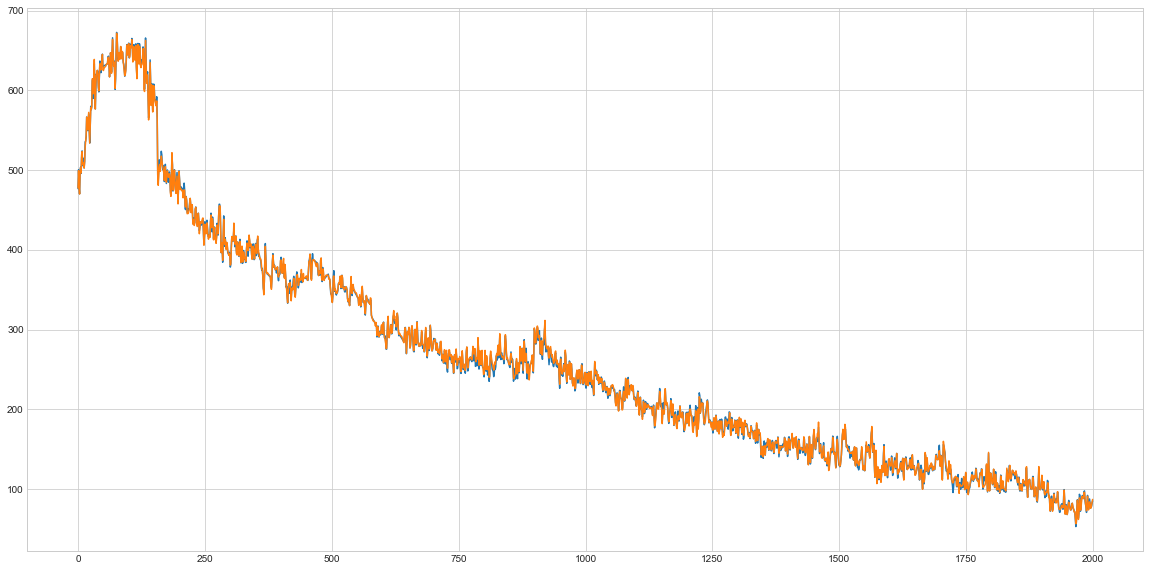

In [33]:
gbest = PSO.train(target2, 100, 1, 0.01)

In [35]:
print('BP fitting loss:',torch.mean(torch.abs(target2 - model_eeg1.pred(input_)[1])))
print('APSO fitting loss:',torch.mean(torch.abs(target2 - PSO.rbfnn(gbest))))

BP fitting loss: tensor(1.8780, device='cuda:0', dtype=torch.float64)
APSO fitting loss: tensor(2.3327, device='cuda:0', dtype=torch.float64)


In [34]:
print('BP fitting loss:',torch.mean(torch.abs(target2 - model_eeg1.pred(input_)[1])))
print('APSO fitting loss:',torch.mean(torch.abs(target2 - PSO.rbfnn(gbest))))

BP fitting loss: tensor(1.8780, device='cuda:0', dtype=torch.float64)
APSO fitting loss: tensor(2.3327, device='cuda:0', dtype=torch.float64)


<Figure size 2160x720 with 0 Axes>

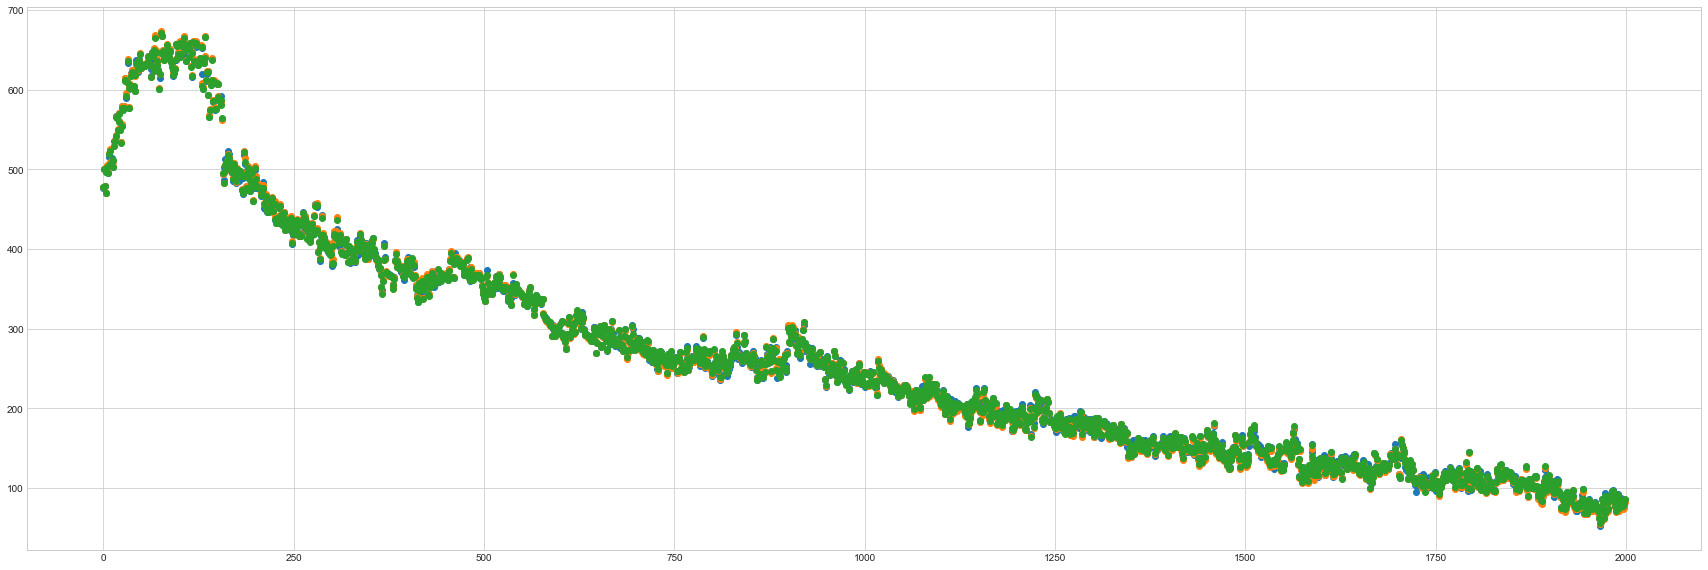

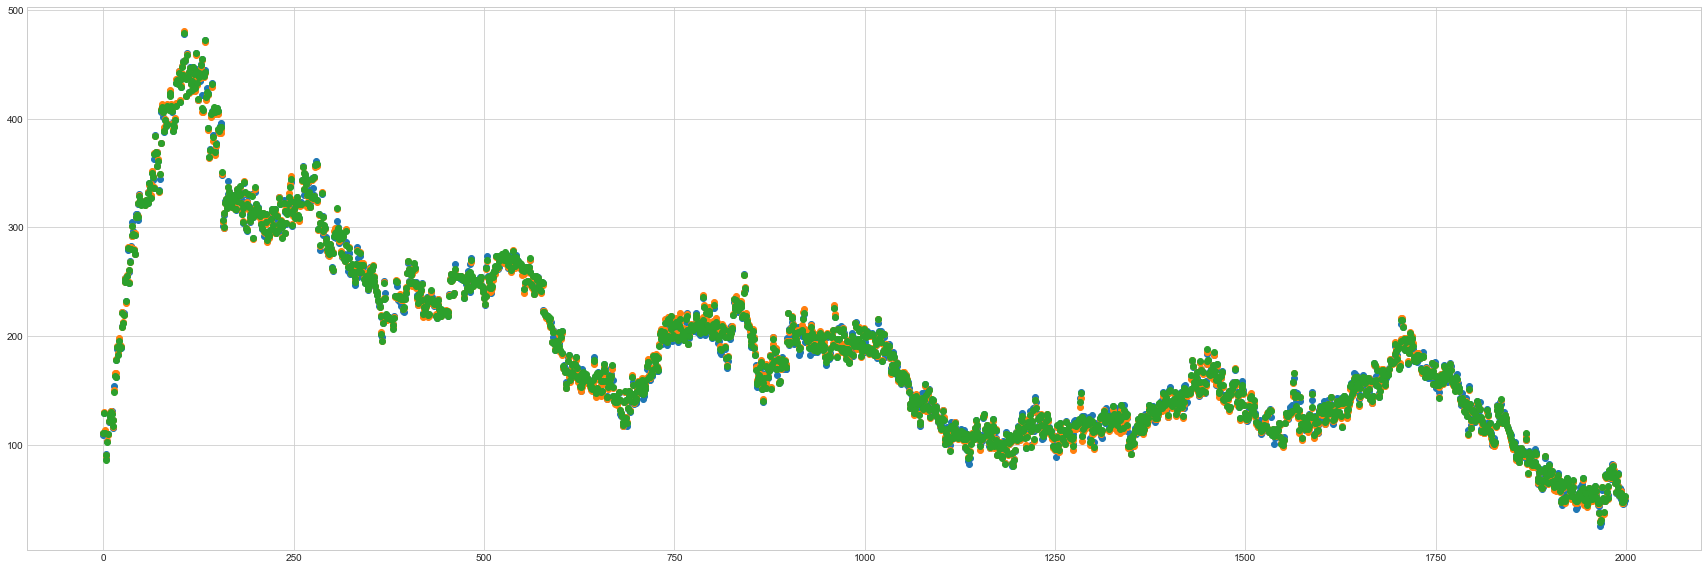

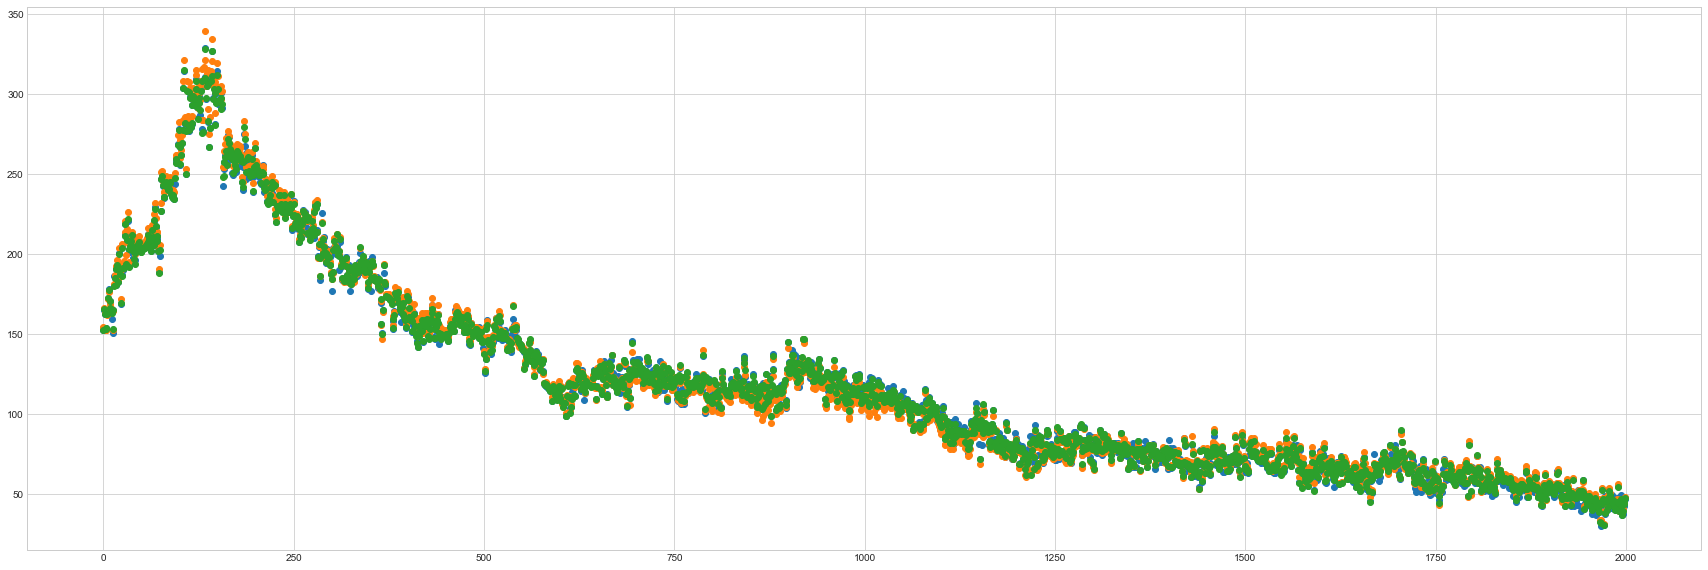

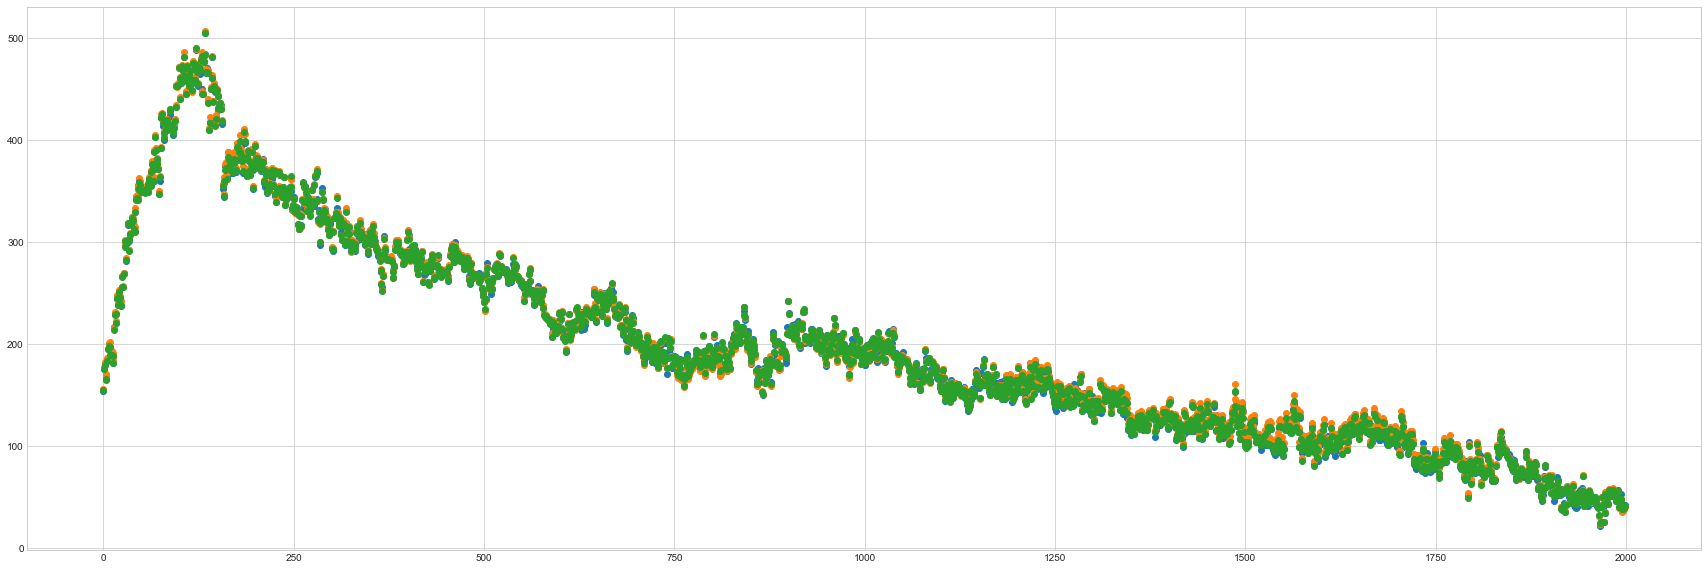

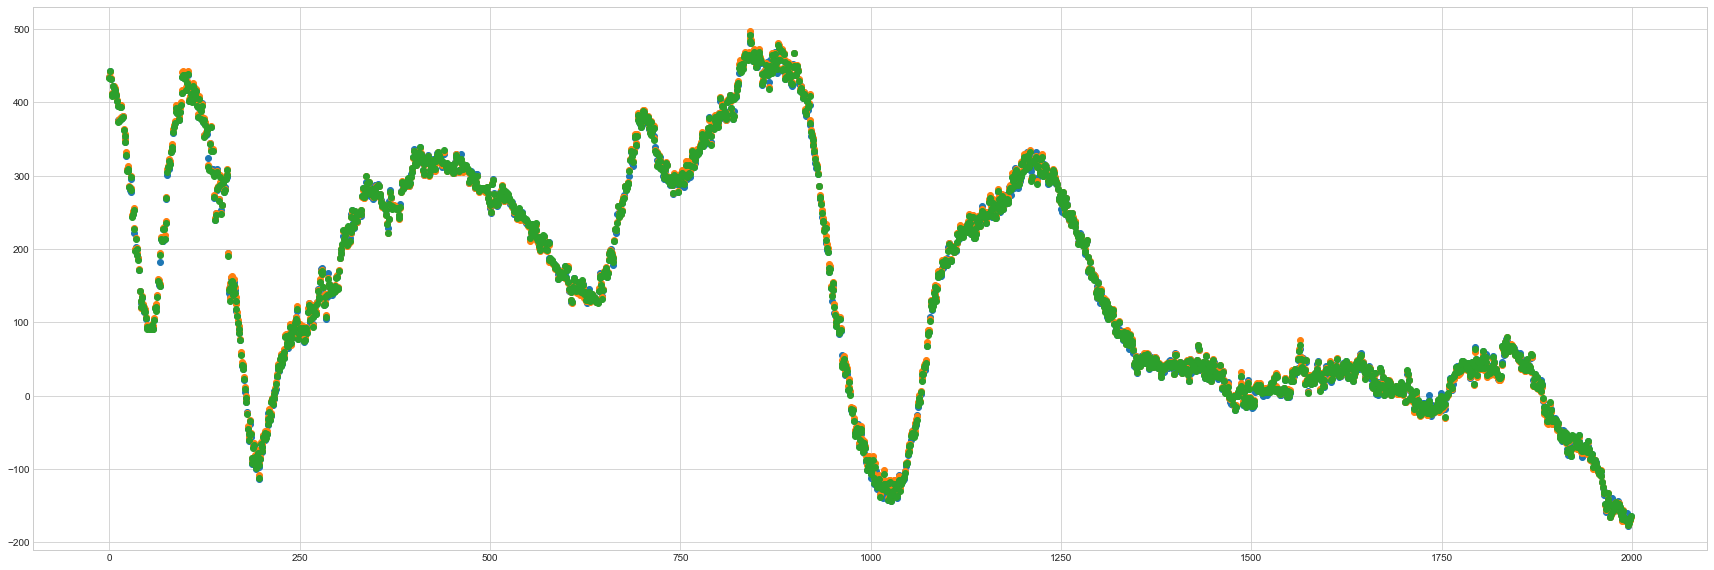

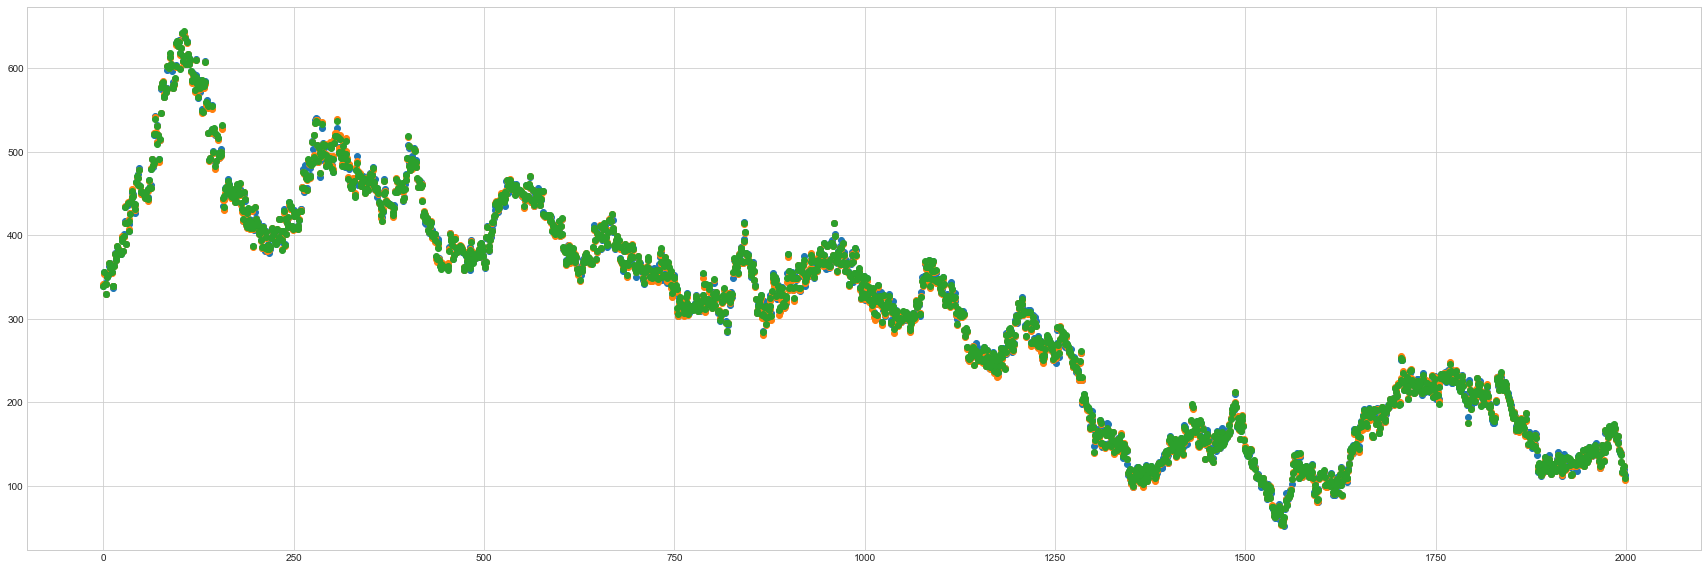

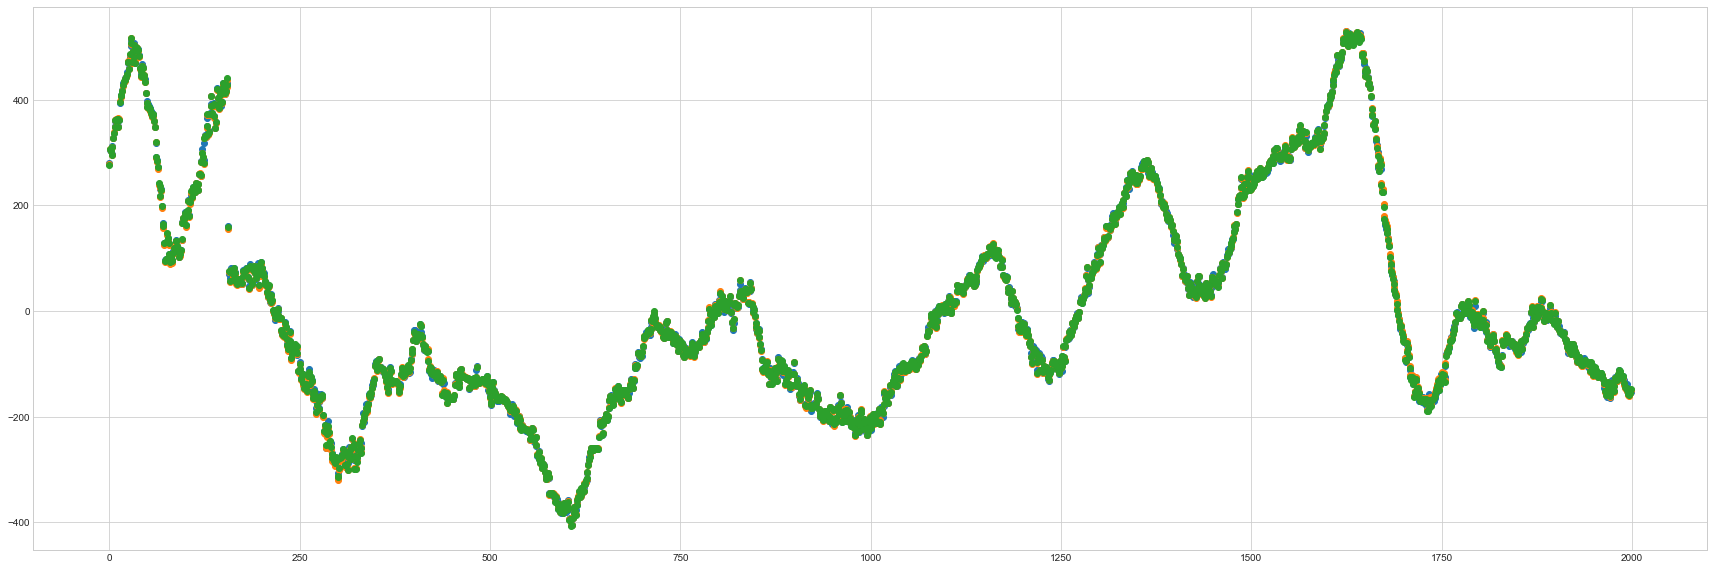

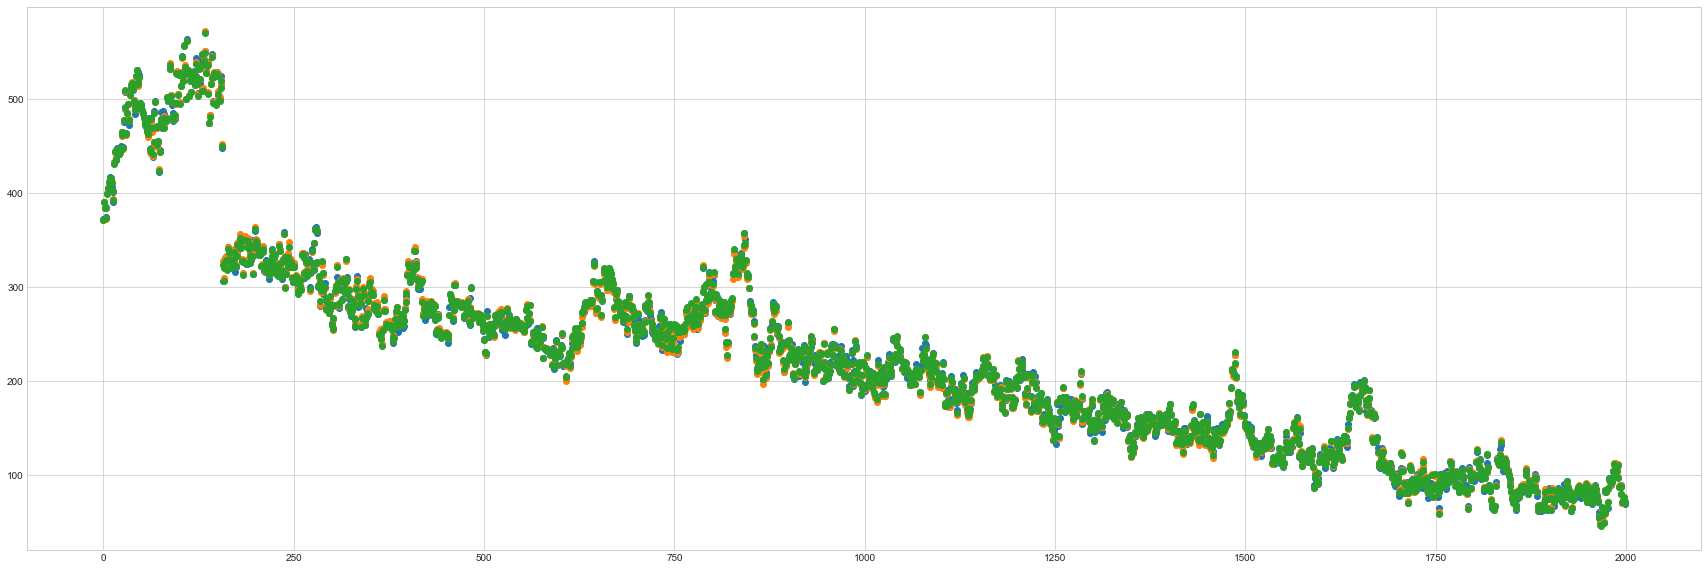

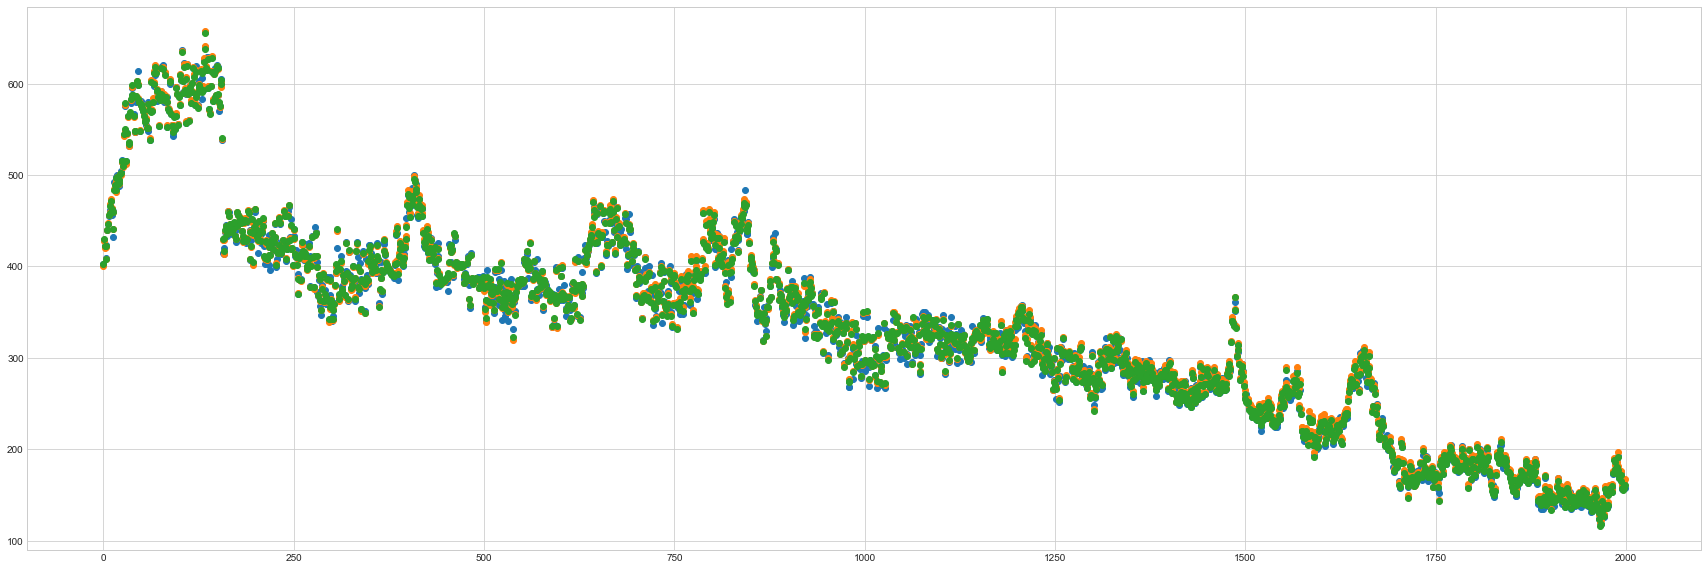

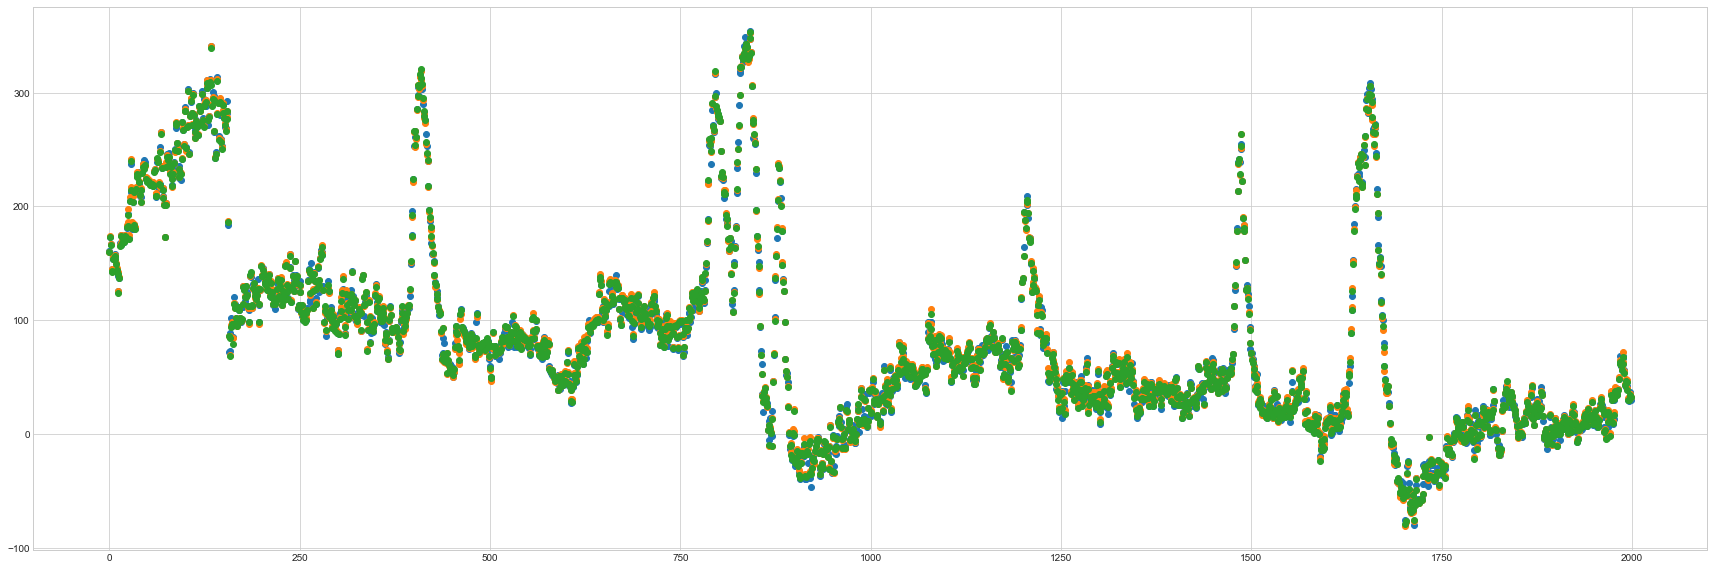

In [32]:
plt.figure(figsize=(30, 10))
model_pred = model_eeg1.pred(input_)[1]
for i in range(target2.size(0)):
    plt.figure(figsize=(30, 10))
    plt.scatter(input_.cpu().detach().numpy(), target2[i].cpu().detach().numpy())
    plt.scatter(input_.cpu().detach().numpy(), PSO.rbfnn(gbest)[i].cpu().detach().numpy())
    plt.scatter(input_.cpu().detach().numpy(), model_pred[i].cpu().detach().numpy())
    plt.show()

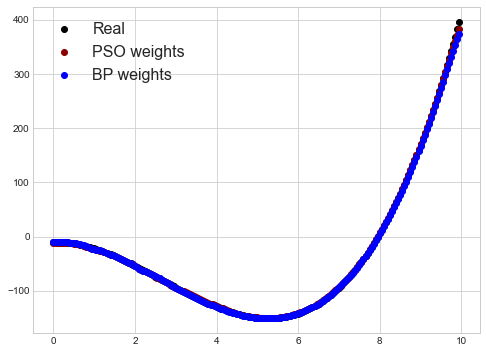

In [47]:
plt.figure(figsize=(8,6))
plt.scatter(input_2.cpu().detach().numpy(), target3[0].cpu().detach().numpy(),label='Real', linewidths = 1.0, color = 'black',zorder=2)
plt.scatter(input_2.cpu().detach().numpy(), PSO.rbfnn(gbest)[0].cpu().detach().numpy(),label='PSO weights', linewidths = 1.0, color = 'darkred',zorder=2)
plt.scatter(input_2.cpu().detach().numpy(), model2.pred(input_2)[1][0].cpu().detach().numpy(),label='BP weights', linewidths = 1.0, color = 'blue',zorder=2)
plt.legend(fontsize = 16,facecolor='white',edgecolor='black',fancybox=True)

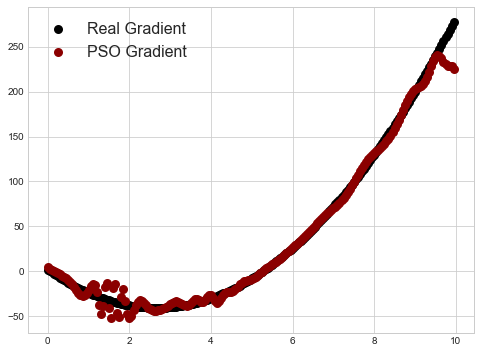

In [48]:
rbf_grad3 = rbf_gradient(input_2, model2.done_radial_layer_centers, model2.done_radial_sigma, gbest)
plt.figure(figsize=(8,6))
plt.scatter(input_2.cpu().detach().numpy(), poly_gr.cpu().detach().numpy(),label='Real Gradient', linewidths = 3.0, color = 'black',zorder=2)
plt.scatter(input_2.cpu().detach().numpy(), rbf_grad3[0].cpu().detach().numpy(),label='PSO Gradient', linewidths = 3.0, color = 'darkred',zorder=2)
plt.legend(fontsize = 16,facecolor='white',edgecolor='black',fancybox=True)
plt.show()

In [49]:
print('BP gradient loss:',torch.mean(torch.abs(poly_gr - rbf_grad2[0])))
print('APSO gradient loss:',torch.mean(torch.abs(poly_gr - rbf_grad3[0])))

BP gradient loss: tensor(5.4507, device='cuda:0', dtype=torch.float64)
APSO gradient loss: tensor(4.6712, device='cuda:0', dtype=torch.float64)
